In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1_normalized_k5_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 1380)
(772408, 8)
validation
(101248, 1380)
(101248, 8)
test
(98888, 1380)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1380)]            0         


 dense (Dense)               (None, 1024)              1414144   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2104200 (8.03 MB)


Trainable params: 2104200 (8.03 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:47 - loss: 2.2282 - STD: 0.0536 - MAE: 0.2221

 4/78 [>.............................] - ETA: 1s - loss: 1.6906 - STD: 0.1087 - MAE: 0.1847  

 6/78 [=>............................] - ETA: 1s - loss: 1.5874 - STD: 0.1500 - MAE: 0.1667

 8/78 [==>...........................] - ETA: 2s - loss: 1.5371 - STD: 0.1734 - MAE: 0.1566

10/78 [==>...........................] - ETA: 2s - loss: 1.4992 - STD: 0.1844 - MAE: 0.1516

12/78 [===>..........................] - ETA: 2s - loss: 1.4712 - STD: 0.1873 - MAE: 0.1499

14/78 [====>.........................] - ETA: 2s - loss: 1.4529 - STD: 0.1863 - MAE: 0.1499

16/78 [=====>........................] - ETA: 2s - loss: 1.4398 - STD: 0.1847 - MAE: 0.1504

18/78 [=====>........................] - ETA: 2s - loss: 1.4286 - STD: 0.1840 - MAE: 0.1504

20/78 [======>.......................] - ETA: 2s - loss: 1.4195 - STD: 0.1847 - MAE: 0.1500

22/78 [=======>......................] - ETA: 1s - loss: 1.4111 - STD: 0.1862 - MAE: 0.1493

24/78 [========>.....................] - ETA: 1s - loss: 1.4057 - STD: 0.1879 - MAE: 0.1486

26/78 [=========>....................] - ETA: 1s - loss: 1.4002 - STD: 0.1892 - MAE: 0.1479

28/78 [=========>....................] - ETA: 1s - loss: 1.3941 - STD: 0.1900 - MAE: 0.1475

30/78 [==========>...................] - ETA: 1s - loss: 1.3904 - STD: 0.1902 - MAE: 0.1474

32/78 [===========>..................] - ETA: 1s - loss: 1.3872 - STD: 0.1900 - MAE: 0.1474

34/78 [============>.................] - ETA: 1s - loss: 1.3835 - STD: 0.1896 - MAE: 0.1475

36/78 [============>.................] - ETA: 1s - loss: 1.3795 - STD: 0.1893 - MAE: 0.1475

38/78 [=============>................] - ETA: 1s - loss: 1.3762 - STD: 0.1893 - MAE: 0.1475

40/78 [==============>...............] - ETA: 1s - loss: 1.3734 - STD: 0.1895 - MAE: 0.1473

42/78 [===============>..............] - ETA: 1s - loss: 1.3706 - STD: 0.1899 - MAE: 0.1471

44/78 [===============>..............] - ETA: 1s - loss: 1.3680 - STD: 0.1903 - MAE: 0.1469

46/78 [================>.............] - ETA: 1s - loss: 1.3662 - STD: 0.1906 - MAE: 0.1468

48/78 [=================>............] - ETA: 1s - loss: 1.3642 - STD: 0.1906 - MAE: 0.1467

50/78 [==================>...........] - ETA: 1s - loss: 1.3623 - STD: 0.1905 - MAE: 0.1467

52/78 [===================>..........] - ETA: 0s - loss: 1.3606 - STD: 0.1903 - MAE: 0.1468

54/78 [===================>..........] - ETA: 0s - loss: 1.3589 - STD: 0.1902 - MAE: 0.1468

56/78 [====================>.........] - ETA: 0s - loss: 1.3567 - STD: 0.1901 - MAE: 0.1467

57/78 [====================>.........] - ETA: 1s - loss: 1.3565 - STD: 0.1902 - MAE: 0.1467

60/78 [======================>.......] - ETA: 0s - loss: 1.3547 - STD: 0.1904 - MAE: 0.1466

63/78 [=======================>......] - ETA: 0s - loss: 1.3526 - STD: 0.1906 - MAE: 0.1464

65/78 [========================>.....] - ETA: 0s - loss: 1.3514 - STD: 0.1907 - MAE: 0.1464

67/78 [========================>.....] - ETA: 0s - loss: 1.3500 - STD: 0.1907 - MAE: 0.1464

69/78 [=========================>....] - ETA: 0s - loss: 1.3488 - STD: 0.1906 - MAE: 0.1463

71/78 [==========================>...] - ETA: 0s - loss: 1.3476 - STD: 0.1906 - MAE: 0.1463

73/78 [===========================>..] - ETA: 0s - loss: 1.3468 - STD: 0.1907 - MAE: 0.1463

75/78 [===========================>..] - ETA: 0s - loss: 1.3458 - STD: 0.1908 - MAE: 0.1462

77/78 [============================>.] - ETA: 0s - loss: 1.3446 - STD: 0.1909 - MAE: 0.1462

78/78 [==============================] - 6s 58ms/step - loss: 1.3442 - STD: 0.1909 - MAE: 0.1461 - val_loss: 1.2732 - val_STD: 0.1948 - val_MAE: 0.1437


Epoch 2/10000


 1/78 [..............................] - ETA: 5s - loss: 1.3241 - STD: 0.1948 - MAE: 0.1443

 3/78 [>.............................] - ETA: 2s - loss: 1.3169 - STD: 0.1942 - MAE: 0.1443

 5/78 [>.............................] - ETA: 2s - loss: 1.3224 - STD: 0.1934 - MAE: 0.1449

 7/78 [=>............................] - ETA: 2s - loss: 1.3238 - STD: 0.1925 - MAE: 0.1454

 9/78 [==>...........................] - ETA: 2s - loss: 1.3212 - STD: 0.1916 - MAE: 0.1456

11/78 [===>..........................] - ETA: 2s - loss: 1.3193 - STD: 0.1910 - MAE: 0.1458

13/78 [====>.........................] - ETA: 2s - loss: 1.3196 - STD: 0.1908 - MAE: 0.1459

15/78 [====>.........................] - ETA: 2s - loss: 1.3191 - STD: 0.1910 - MAE: 0.1457

17/78 [=====>........................] - ETA: 2s - loss: 1.3184 - STD: 0.1914 - MAE: 0.1455

19/78 [======>.......................] - ETA: 2s - loss: 1.3187 - STD: 0.1917 - MAE: 0.1454

21/78 [=======>......................] - ETA: 2s - loss: 1.3181 - STD: 0.1918 - MAE: 0.1454

23/78 [=======>......................] - ETA: 2s - loss: 1.3177 - STD: 0.1916 - MAE: 0.1454

25/78 [========>.....................] - ETA: 2s - loss: 1.3172 - STD: 0.1914 - MAE: 0.1455

27/78 [=========>....................] - ETA: 1s - loss: 1.3167 - STD: 0.1913 - MAE: 0.1455

29/78 [==========>...................] - ETA: 1s - loss: 1.3173 - STD: 0.1914 - MAE: 0.1455

31/78 [==========>...................] - ETA: 1s - loss: 1.3173 - STD: 0.1915 - MAE: 0.1454

33/78 [===========>..................] - ETA: 1s - loss: 1.3174 - STD: 0.1916 - MAE: 0.1454

35/78 [============>.................] - ETA: 1s - loss: 1.3177 - STD: 0.1915 - MAE: 0.1455

37/78 [=============>................] - ETA: 1s - loss: 1.3169 - STD: 0.1913 - MAE: 0.1455

39/78 [==============>...............] - ETA: 1s - loss: 1.3168 - STD: 0.1913 - MAE: 0.1455

41/78 [==============>...............] - ETA: 1s - loss: 1.3168 - STD: 0.1914 - MAE: 0.1455

43/78 [===============>..............] - ETA: 1s - loss: 1.3165 - STD: 0.1915 - MAE: 0.1454

45/78 [================>.............] - ETA: 1s - loss: 1.3162 - STD: 0.1916 - MAE: 0.1454

47/78 [=================>............] - ETA: 1s - loss: 1.3159 - STD: 0.1917 - MAE: 0.1453

49/78 [=================>............] - ETA: 1s - loss: 1.3158 - STD: 0.1916 - MAE: 0.1453

51/78 [==================>...........] - ETA: 1s - loss: 1.3158 - STD: 0.1916 - MAE: 0.1454

53/78 [===================>..........] - ETA: 0s - loss: 1.3163 - STD: 0.1915 - MAE: 0.1454

55/78 [====================>.........] - ETA: 0s - loss: 1.3160 - STD: 0.1915 - MAE: 0.1454

58/78 [=====================>........] - ETA: 0s - loss: 1.3162 - STD: 0.1915 - MAE: 0.1454

60/78 [======================>.......] - ETA: 0s - loss: 1.3158 - STD: 0.1916 - MAE: 0.1454

62/78 [======================>.......] - ETA: 0s - loss: 1.3161 - STD: 0.1917 - MAE: 0.1453

64/78 [=======================>......] - ETA: 0s - loss: 1.3160 - STD: 0.1917 - MAE: 0.1453

66/78 [========================>.....] - ETA: 0s - loss: 1.3158 - STD: 0.1917 - MAE: 0.1453

68/78 [=========================>....] - ETA: 0s - loss: 1.3161 - STD: 0.1916 - MAE: 0.1454

70/78 [=========================>....] - ETA: 0s - loss: 1.3160 - STD: 0.1916 - MAE: 0.1454

72/78 [==========================>...] - ETA: 0s - loss: 1.3159 - STD: 0.1915 - MAE: 0.1454

74/78 [===========================>..] - ETA: 0s - loss: 1.3161 - STD: 0.1916 - MAE: 0.1454

76/78 [============================>.] - ETA: 0s - loss: 1.3163 - STD: 0.1916 - MAE: 0.1454

78/78 [==============================] - ETA: 0s - loss: 1.3165 - STD: 0.1916 - MAE: 0.1454

78/78 [==============================] - 3s 43ms/step - loss: 1.3165 - STD: 0.1916 - MAE: 0.1454 - val_loss: 1.2740 - val_STD: 0.1902 - val_MAE: 0.1455


Epoch 3/10000


 1/78 [..............................] - ETA: 5s - loss: 1.3149 - STD: 0.1901 - MAE: 0.1458

 3/78 [>.............................] - ETA: 3s - loss: 1.3168 - STD: 0.1893 - MAE: 0.1463

 5/78 [>.............................] - ETA: 2s - loss: 1.3144 - STD: 0.1891 - MAE: 0.1462

 7/78 [=>............................] - ETA: 2s - loss: 1.3127 - STD: 0.1898 - MAE: 0.1459

 9/78 [==>...........................] - ETA: 2s - loss: 1.3144 - STD: 0.1908 - MAE: 0.1456

11/78 [===>..........................] - ETA: 2s - loss: 1.3182 - STD: 0.1913 - MAE: 0.1456

13/78 [====>.........................] - ETA: 2s - loss: 1.3160 - STD: 0.1911 - MAE: 0.1455

15/78 [====>.........................] - ETA: 2s - loss: 1.3155 - STD: 0.1910 - MAE: 0.1456

17/78 [=====>........................] - ETA: 2s - loss: 1.3148 - STD: 0.1910 - MAE: 0.1455

19/78 [======>.......................] - ETA: 2s - loss: 1.3148 - STD: 0.1912 - MAE: 0.1454

21/78 [=======>......................] - ETA: 2s - loss: 1.3148 - STD: 0.1914 - MAE: 0.1454

23/78 [=======>......................] - ETA: 2s - loss: 1.3154 - STD: 0.1915 - MAE: 0.1454

25/78 [========>.....................] - ETA: 2s - loss: 1.3157 - STD: 0.1914 - MAE: 0.1454

27/78 [=========>....................] - ETA: 1s - loss: 1.3161 - STD: 0.1912 - MAE: 0.1455

29/78 [==========>...................] - ETA: 1s - loss: 1.3157 - STD: 0.1910 - MAE: 0.1456

31/78 [==========>...................] - ETA: 1s - loss: 1.3161 - STD: 0.1910 - MAE: 0.1456

33/78 [===========>..................] - ETA: 1s - loss: 1.3165 - STD: 0.1912 - MAE: 0.1456

35/78 [============>.................] - ETA: 1s - loss: 1.3164 - STD: 0.1913 - MAE: 0.1455

37/78 [=============>................] - ETA: 1s - loss: 1.3164 - STD: 0.1913 - MAE: 0.1455

39/78 [==============>...............] - ETA: 1s - loss: 1.3164 - STD: 0.1912 - MAE: 0.1455

41/78 [==============>...............] - ETA: 1s - loss: 1.3167 - STD: 0.1912 - MAE: 0.1456

43/78 [===============>..............] - ETA: 1s - loss: 1.3164 - STD: 0.1912 - MAE: 0.1456

45/78 [================>.............] - ETA: 1s - loss: 1.3163 - STD: 0.1912 - MAE: 0.1455

47/78 [=================>............] - ETA: 1s - loss: 1.3159 - STD: 0.1913 - MAE: 0.1455

49/78 [=================>............] - ETA: 1s - loss: 1.3153 - STD: 0.1913 - MAE: 0.1454

51/78 [==================>...........] - ETA: 1s - loss: 1.3153 - STD: 0.1915 - MAE: 0.1454

53/78 [===================>..........] - ETA: 0s - loss: 1.3156 - STD: 0.1915 - MAE: 0.1454

55/78 [====================>.........] - ETA: 0s - loss: 1.3155 - STD: 0.1915 - MAE: 0.1454

57/78 [====================>.........] - ETA: 0s - loss: 1.3157 - STD: 0.1914 - MAE: 0.1454

59/78 [=====================>........] - ETA: 0s - loss: 1.3157 - STD: 0.1913 - MAE: 0.1454

61/78 [======================>.......] - ETA: 0s - loss: 1.3158 - STD: 0.1913 - MAE: 0.1455

63/78 [=======================>......] - ETA: 0s - loss: 1.3158 - STD: 0.1913 - MAE: 0.1454

65/78 [========================>.....] - ETA: 0s - loss: 1.3159 - STD: 0.1913 - MAE: 0.1454

67/78 [========================>.....] - ETA: 0s - loss: 1.3157 - STD: 0.1913 - MAE: 0.1454

69/78 [=========================>....] - ETA: 0s - loss: 1.3157 - STD: 0.1913 - MAE: 0.1455

71/78 [==========================>...] - ETA: 0s - loss: 1.3152 - STD: 0.1913 - MAE: 0.1454

73/78 [===========================>..] - ETA: 0s - loss: 1.3155 - STD: 0.1914 - MAE: 0.1454

76/78 [============================>.] - ETA: 0s - loss: 1.3153 - STD: 0.1913 - MAE: 0.1455

78/78 [==============================] - ETA: 0s - loss: 1.3152 - STD: 0.1912 - MAE: 0.1455

78/78 [==============================] - 3s 43ms/step - loss: 1.3152 - STD: 0.1912 - MAE: 0.1455 - val_loss: 1.2701 - val_STD: 0.1976 - val_MAE: 0.1425


Epoch 4/10000


 1/78 [..............................] - ETA: 6s - loss: 1.3064 - STD: 0.1940 - MAE: 0.1437

 3/78 [>.............................] - ETA: 2s - loss: 1.3058 - STD: 0.1922 - MAE: 0.1445

 5/78 [>.............................] - ETA: 2s - loss: 1.3064 - STD: 0.1908 - MAE: 0.1452

 7/78 [=>............................] - ETA: 2s - loss: 1.3068 - STD: 0.1912 - MAE: 0.1450

 9/78 [==>...........................] - ETA: 2s - loss: 1.3091 - STD: 0.1913 - MAE: 0.1450

11/78 [===>..........................] - ETA: 2s - loss: 1.3091 - STD: 0.1912 - MAE: 0.1450

13/78 [====>.........................] - ETA: 2s - loss: 1.3080 - STD: 0.1919 - MAE: 0.1447

15/78 [====>.........................] - ETA: 2s - loss: 1.3068 - STD: 0.1914 - MAE: 0.1449

17/78 [=====>........................] - ETA: 2s - loss: 1.3065 - STD: 0.1915 - MAE: 0.1448

19/78 [======>.......................] - ETA: 2s - loss: 1.3049 - STD: 0.1912 - MAE: 0.1449

21/78 [=======>......................] - ETA: 2s - loss: 1.3044 - STD: 0.1915 - MAE: 0.1447

23/78 [=======>......................] - ETA: 2s - loss: 1.3030 - STD: 0.1915 - MAE: 0.1446

25/78 [========>.....................] - ETA: 2s - loss: 1.3030 - STD: 0.1916 - MAE: 0.1446

27/78 [=========>....................] - ETA: 1s - loss: 1.3015 - STD: 0.1920 - MAE: 0.1444

29/78 [==========>...................] - ETA: 1s - loss: 1.3008 - STD: 0.1920 - MAE: 0.1443

31/78 [==========>...................] - ETA: 1s - loss: 1.3006 - STD: 0.1923 - MAE: 0.1442

33/78 [===========>..................] - ETA: 1s - loss: 1.3006 - STD: 0.1918 - MAE: 0.1444

35/78 [============>.................] - ETA: 1s - loss: 1.2999 - STD: 0.1921 - MAE: 0.1443

37/78 [=============>................] - ETA: 1s - loss: 1.2993 - STD: 0.1919 - MAE: 0.1443

39/78 [==============>...............] - ETA: 1s - loss: 1.2988 - STD: 0.1924 - MAE: 0.1441

42/78 [===============>..............] - ETA: 1s - loss: 1.2988 - STD: 0.1922 - MAE: 0.1442

44/78 [===============>..............] - ETA: 1s - loss: 1.2976 - STD: 0.1925 - MAE: 0.1441

46/78 [================>.............] - ETA: 1s - loss: 1.2964 - STD: 0.1924 - MAE: 0.1441

48/78 [=================>............] - ETA: 1s - loss: 1.2958 - STD: 0.1925 - MAE: 0.1440

50/78 [==================>...........] - ETA: 1s - loss: 1.2946 - STD: 0.1927 - MAE: 0.1439

52/78 [===================>..........] - ETA: 0s - loss: 1.2937 - STD: 0.1928 - MAE: 0.1438

54/78 [===================>..........] - ETA: 0s - loss: 1.2928 - STD: 0.1929 - MAE: 0.1437

56/78 [====================>.........] - ETA: 0s - loss: 1.2921 - STD: 0.1931 - MAE: 0.1436

58/78 [=====================>........] - ETA: 0s - loss: 1.2912 - STD: 0.1931 - MAE: 0.1436

60/78 [======================>.......] - ETA: 0s - loss: 1.2905 - STD: 0.1933 - MAE: 0.1435

62/78 [======================>.......] - ETA: 0s - loss: 1.2902 - STD: 0.1932 - MAE: 0.1435

64/78 [=======================>......] - ETA: 0s - loss: 1.2897 - STD: 0.1933 - MAE: 0.1435

66/78 [========================>.....] - ETA: 0s - loss: 1.2890 - STD: 0.1934 - MAE: 0.1434

68/78 [=========================>....] - ETA: 0s - loss: 1.2888 - STD: 0.1934 - MAE: 0.1435

70/78 [=========================>....] - ETA: 0s - loss: 1.2885 - STD: 0.1934 - MAE: 0.1434

72/78 [==========================>...] - ETA: 0s - loss: 1.2874 - STD: 0.1936 - MAE: 0.1433

74/78 [===========================>..] - ETA: 0s - loss: 1.2870 - STD: 0.1937 - MAE: 0.1433

76/78 [============================>.] - ETA: 0s - loss: 1.2865 - STD: 0.1936 - MAE: 0.1433

78/78 [==============================] - ETA: 0s - loss: 1.2862 - STD: 0.1937 - MAE: 0.1433

78/78 [==============================] - 3s 43ms/step - loss: 1.2862 - STD: 0.1937 - MAE: 0.1433 - val_loss: 1.2300 - val_STD: 0.1879 - val_MAE: 0.1449


Epoch 5/10000


 1/78 [..............................] - ETA: 6s - loss: 1.2631 - STD: 0.1864 - MAE: 0.1455

 3/78 [>.............................] - ETA: 2s - loss: 1.2748 - STD: 0.1945 - MAE: 0.1429

 5/78 [>.............................] - ETA: 2s - loss: 1.2666 - STD: 0.1933 - MAE: 0.1429

 7/78 [=>............................] - ETA: 2s - loss: 1.2678 - STD: 0.1953 - MAE: 0.1422

 9/78 [==>...........................] - ETA: 2s - loss: 1.2651 - STD: 0.1958 - MAE: 0.1419

11/78 [===>..........................] - ETA: 2s - loss: 1.2637 - STD: 0.1946 - MAE: 0.1424

13/78 [====>.........................] - ETA: 2s - loss: 1.2640 - STD: 0.1947 - MAE: 0.1424

15/78 [====>.........................] - ETA: 2s - loss: 1.2652 - STD: 0.1944 - MAE: 0.1426

17/78 [=====>........................] - ETA: 2s - loss: 1.2658 - STD: 0.1950 - MAE: 0.1424

19/78 [======>.......................] - ETA: 2s - loss: 1.2630 - STD: 0.1951 - MAE: 0.1423

21/78 [=======>......................] - ETA: 2s - loss: 1.2625 - STD: 0.1949 - MAE: 0.1423

23/78 [=======>......................] - ETA: 2s - loss: 1.2621 - STD: 0.1950 - MAE: 0.1423

25/78 [========>.....................] - ETA: 1s - loss: 1.2610 - STD: 0.1951 - MAE: 0.1422

28/78 [=========>....................] - ETA: 1s - loss: 1.2600 - STD: 0.1953 - MAE: 0.1420

30/78 [==========>...................] - ETA: 1s - loss: 1.2590 - STD: 0.1955 - MAE: 0.1419

32/78 [===========>..................] - ETA: 1s - loss: 1.2579 - STD: 0.1955 - MAE: 0.1419

34/78 [============>.................] - ETA: 1s - loss: 1.2563 - STD: 0.1955 - MAE: 0.1418

36/78 [============>.................] - ETA: 1s - loss: 1.2555 - STD: 0.1955 - MAE: 0.1418

38/78 [=============>................] - ETA: 1s - loss: 1.2553 - STD: 0.1954 - MAE: 0.1418

40/78 [==============>...............] - ETA: 1s - loss: 1.2548 - STD: 0.1957 - MAE: 0.1417

42/78 [===============>..............] - ETA: 1s - loss: 1.2548 - STD: 0.1956 - MAE: 0.1418

44/78 [===============>..............] - ETA: 1s - loss: 1.2537 - STD: 0.1955 - MAE: 0.1417

46/78 [================>.............] - ETA: 1s - loss: 1.2533 - STD: 0.1957 - MAE: 0.1416

48/78 [=================>............] - ETA: 1s - loss: 1.2526 - STD: 0.1959 - MAE: 0.1416

50/78 [==================>...........] - ETA: 1s - loss: 1.2513 - STD: 0.1957 - MAE: 0.1416

52/78 [===================>..........] - ETA: 0s - loss: 1.2504 - STD: 0.1957 - MAE: 0.1415

54/78 [===================>..........] - ETA: 0s - loss: 1.2501 - STD: 0.1959 - MAE: 0.1415

56/78 [====================>.........] - ETA: 0s - loss: 1.2498 - STD: 0.1958 - MAE: 0.1415

58/78 [=====================>........] - ETA: 0s - loss: 1.2492 - STD: 0.1957 - MAE: 0.1415

60/78 [======================>.......] - ETA: 0s - loss: 1.2484 - STD: 0.1958 - MAE: 0.1415

62/78 [======================>.......] - ETA: 0s - loss: 1.2474 - STD: 0.1959 - MAE: 0.1414

64/78 [=======================>......] - ETA: 0s - loss: 1.2472 - STD: 0.1958 - MAE: 0.1414

66/78 [========================>.....] - ETA: 0s - loss: 1.2464 - STD: 0.1959 - MAE: 0.1414

68/78 [=========================>....] - ETA: 0s - loss: 1.2459 - STD: 0.1961 - MAE: 0.1413

70/78 [=========================>....] - ETA: 0s - loss: 1.2456 - STD: 0.1960 - MAE: 0.1413

72/78 [==========================>...] - ETA: 0s - loss: 1.2453 - STD: 0.1959 - MAE: 0.1414

74/78 [===========================>..] - ETA: 0s - loss: 1.2446 - STD: 0.1961 - MAE: 0.1412

76/78 [============================>.] - ETA: 0s - loss: 1.2445 - STD: 0.1961 - MAE: 0.1412

78/78 [==============================] - ETA: 0s - loss: 1.2442 - STD: 0.1960 - MAE: 0.1413

78/78 [==============================] - 3s 44ms/step - loss: 1.2442 - STD: 0.1960 - MAE: 0.1413 - val_loss: 1.1866 - val_STD: 0.1983 - val_MAE: 0.1395


Epoch 6/10000


 1/78 [..............................] - ETA: 4s - loss: 1.2089 - STD: 0.1937 - MAE: 0.1408

 3/78 [>.............................] - ETA: 2s - loss: 1.2219 - STD: 0.2005 - MAE: 0.1389

 5/78 [>.............................] - ETA: 2s - loss: 1.2217 - STD: 0.1978 - MAE: 0.1400

 7/78 [=>............................] - ETA: 2s - loss: 1.2197 - STD: 0.1967 - MAE: 0.1403

 9/78 [==>...........................] - ETA: 2s - loss: 1.2219 - STD: 0.1984 - MAE: 0.1397

11/78 [===>..........................] - ETA: 2s - loss: 1.2209 - STD: 0.1981 - MAE: 0.1398

13/78 [====>.........................] - ETA: 2s - loss: 1.2196 - STD: 0.1975 - MAE: 0.1400

15/78 [====>.........................] - ETA: 2s - loss: 1.2175 - STD: 0.1983 - MAE: 0.1396

17/78 [=====>........................] - ETA: 2s - loss: 1.2164 - STD: 0.1983 - MAE: 0.1395

19/78 [======>.......................] - ETA: 2s - loss: 1.2154 - STD: 0.1984 - MAE: 0.1394

21/78 [=======>......................] - ETA: 2s - loss: 1.2161 - STD: 0.1985 - MAE: 0.1394

23/78 [=======>......................] - ETA: 2s - loss: 1.2164 - STD: 0.1983 - MAE: 0.1395

25/78 [========>.....................] - ETA: 1s - loss: 1.2155 - STD: 0.1982 - MAE: 0.1395

27/78 [=========>....................] - ETA: 1s - loss: 1.2145 - STD: 0.1983 - MAE: 0.1394

29/78 [==========>...................] - ETA: 1s - loss: 1.2127 - STD: 0.1985 - MAE: 0.1393

31/78 [==========>...................] - ETA: 1s - loss: 1.2125 - STD: 0.1985 - MAE: 0.1393

33/78 [===========>..................] - ETA: 1s - loss: 1.2116 - STD: 0.1984 - MAE: 0.1393

35/78 [============>.................] - ETA: 1s - loss: 1.2111 - STD: 0.1987 - MAE: 0.1392

37/78 [=============>................] - ETA: 1s - loss: 1.2106 - STD: 0.1986 - MAE: 0.1392

40/78 [==============>...............] - ETA: 1s - loss: 1.2108 - STD: 0.1990 - MAE: 0.1390

42/78 [===============>..............] - ETA: 1s - loss: 1.2110 - STD: 0.1986 - MAE: 0.1392

44/78 [===============>..............] - ETA: 1s - loss: 1.2103 - STD: 0.1987 - MAE: 0.1391

46/78 [================>.............] - ETA: 1s - loss: 1.2101 - STD: 0.1990 - MAE: 0.1390

48/78 [=================>............] - ETA: 1s - loss: 1.2103 - STD: 0.1987 - MAE: 0.1391

50/78 [==================>...........] - ETA: 1s - loss: 1.2107 - STD: 0.1988 - MAE: 0.1391

52/78 [===================>..........] - ETA: 0s - loss: 1.2099 - STD: 0.1990 - MAE: 0.1390

54/78 [===================>..........] - ETA: 0s - loss: 1.2097 - STD: 0.1990 - MAE: 0.1390

56/78 [====================>.........] - ETA: 0s - loss: 1.2096 - STD: 0.1990 - MAE: 0.1390

58/78 [=====================>........] - ETA: 0s - loss: 1.2089 - STD: 0.1992 - MAE: 0.1389

60/78 [======================>.......] - ETA: 0s - loss: 1.2083 - STD: 0.1991 - MAE: 0.1389

62/78 [======================>.......] - ETA: 0s - loss: 1.2085 - STD: 0.1991 - MAE: 0.1389

64/78 [=======================>......] - ETA: 0s - loss: 1.2084 - STD: 0.1991 - MAE: 0.1389

66/78 [========================>.....] - ETA: 0s - loss: 1.2082 - STD: 0.1992 - MAE: 0.1389

68/78 [=========================>....] - ETA: 0s - loss: 1.2078 - STD: 0.1992 - MAE: 0.1389

70/78 [=========================>....] - ETA: 0s - loss: 1.2072 - STD: 0.1992 - MAE: 0.1388

72/78 [==========================>...] - ETA: 0s - loss: 1.2068 - STD: 0.1992 - MAE: 0.1388

74/78 [===========================>..] - ETA: 0s - loss: 1.2064 - STD: 0.1993 - MAE: 0.1388

76/78 [============================>.] - ETA: 0s - loss: 1.2061 - STD: 0.1993 - MAE: 0.1388

78/78 [==============================] - ETA: 0s - loss: 1.2055 - STD: 0.1992 - MAE: 0.1388

78/78 [==============================] - 3s 43ms/step - loss: 1.2055 - STD: 0.1992 - MAE: 0.1388 - val_loss: 1.1867 - val_STD: 0.2216 - val_MAE: 0.1299


Epoch 7/10000


 1/78 [..............................] - ETA: 5s - loss: 1.1850 - STD: 0.2123 - MAE: 0.1327

 3/78 [>.............................] - ETA: 2s - loss: 1.1896 - STD: 0.2039 - MAE: 0.1363

 5/78 [>.............................] - ETA: 2s - loss: 1.1849 - STD: 0.2031 - MAE: 0.1363

 7/78 [=>............................] - ETA: 2s - loss: 1.1873 - STD: 0.2043 - MAE: 0.1359

 9/78 [==>...........................] - ETA: 2s - loss: 1.1878 - STD: 0.2020 - MAE: 0.1368

11/78 [===>..........................] - ETA: 2s - loss: 1.1871 - STD: 0.2033 - MAE: 0.1363

13/78 [====>.........................] - ETA: 2s - loss: 1.1858 - STD: 0.2024 - MAE: 0.1366

15/78 [====>.........................] - ETA: 2s - loss: 1.1876 - STD: 0.2023 - MAE: 0.1368

17/78 [=====>........................] - ETA: 2s - loss: 1.1873 - STD: 0.2022 - MAE: 0.1368

20/78 [======>.......................] - ETA: 2s - loss: 1.1868 - STD: 0.2024 - MAE: 0.1367

22/78 [=======>......................] - ETA: 2s - loss: 1.1857 - STD: 0.2018 - MAE: 0.1369

24/78 [========>.....................] - ETA: 1s - loss: 1.1865 - STD: 0.2022 - MAE: 0.1368

26/78 [=========>....................] - ETA: 1s - loss: 1.1863 - STD: 0.2021 - MAE: 0.1368

28/78 [=========>....................] - ETA: 1s - loss: 1.1862 - STD: 0.2019 - MAE: 0.1369

30/78 [==========>...................] - ETA: 1s - loss: 1.1863 - STD: 0.2022 - MAE: 0.1368

32/78 [===========>..................] - ETA: 1s - loss: 1.1857 - STD: 0.2017 - MAE: 0.1370

34/78 [============>.................] - ETA: 1s - loss: 1.1859 - STD: 0.2022 - MAE: 0.1368

36/78 [============>.................] - ETA: 1s - loss: 1.1853 - STD: 0.2016 - MAE: 0.1370

38/78 [=============>................] - ETA: 1s - loss: 1.1853 - STD: 0.2020 - MAE: 0.1369

40/78 [==============>...............] - ETA: 1s - loss: 1.1853 - STD: 0.2018 - MAE: 0.1370

42/78 [===============>..............] - ETA: 1s - loss: 1.1861 - STD: 0.2019 - MAE: 0.1369

44/78 [===============>..............] - ETA: 1s - loss: 1.1864 - STD: 0.2022 - MAE: 0.1368

46/78 [================>.............] - ETA: 1s - loss: 1.1865 - STD: 0.2018 - MAE: 0.1370

48/78 [=================>............] - ETA: 1s - loss: 1.1868 - STD: 0.2021 - MAE: 0.1369

50/78 [==================>...........] - ETA: 1s - loss: 1.1873 - STD: 0.2020 - MAE: 0.1370

52/78 [===================>..........] - ETA: 0s - loss: 1.1876 - STD: 0.2018 - MAE: 0.1371

54/78 [===================>..........] - ETA: 0s - loss: 1.1883 - STD: 0.2018 - MAE: 0.1371

56/78 [====================>.........] - ETA: 0s - loss: 1.1880 - STD: 0.2017 - MAE: 0.1371

58/78 [=====================>........] - ETA: 0s - loss: 1.1877 - STD: 0.2018 - MAE: 0.1371

60/78 [======================>.......] - ETA: 0s - loss: 1.1875 - STD: 0.2016 - MAE: 0.1372

62/78 [======================>.......] - ETA: 0s - loss: 1.1866 - STD: 0.2017 - MAE: 0.1371

64/78 [=======================>......] - ETA: 0s - loss: 1.1859 - STD: 0.2018 - MAE: 0.1370

66/78 [========================>.....] - ETA: 0s - loss: 1.1855 - STD: 0.2017 - MAE: 0.1370

68/78 [=========================>....] - ETA: 0s - loss: 1.1852 - STD: 0.2019 - MAE: 0.1369

70/78 [=========================>....] - ETA: 0s - loss: 1.1848 - STD: 0.2017 - MAE: 0.1370

72/78 [==========================>...] - ETA: 0s - loss: 1.1847 - STD: 0.2019 - MAE: 0.1369

74/78 [===========================>..] - ETA: 0s - loss: 1.1847 - STD: 0.2018 - MAE: 0.1370

76/78 [============================>.] - ETA: 0s - loss: 1.1849 - STD: 0.2019 - MAE: 0.1369

78/78 [==============================] - ETA: 0s - loss: 1.1850 - STD: 0.2020 - MAE: 0.1369

78/78 [==============================] - 3s 43ms/step - loss: 1.1850 - STD: 0.2020 - MAE: 0.1369 - val_loss: 1.2405 - val_STD: 0.1950 - val_MAE: 0.1424


Epoch 8/10000


 1/78 [..............................] - ETA: 6s - loss: 1.2323 - STD: 0.1922 - MAE: 0.1431

 3/78 [>.............................] - ETA: 2s - loss: 1.1893 - STD: 0.2034 - MAE: 0.1364

 5/78 [>.............................] - ETA: 2s - loss: 1.1853 - STD: 0.2061 - MAE: 0.1351

 7/78 [=>............................] - ETA: 2s - loss: 1.1934 - STD: 0.2009 - MAE: 0.1375

 9/78 [==>...........................] - ETA: 2s - loss: 1.1937 - STD: 0.2032 - MAE: 0.1366

11/78 [===>..........................] - ETA: 2s - loss: 1.1911 - STD: 0.2041 - MAE: 0.1361

13/78 [====>.........................] - ETA: 2s - loss: 1.1883 - STD: 0.2024 - MAE: 0.1367

15/78 [====>.........................] - ETA: 2s - loss: 1.1885 - STD: 0.2040 - MAE: 0.1361

17/78 [=====>........................] - ETA: 2s - loss: 1.1881 - STD: 0.2032 - MAE: 0.1364

19/78 [======>.......................] - ETA: 2s - loss: 1.1866 - STD: 0.2027 - MAE: 0.1366

21/78 [=======>......................] - ETA: 2s - loss: 1.1870 - STD: 0.2033 - MAE: 0.1364

23/78 [=======>......................] - ETA: 2s - loss: 1.1856 - STD: 0.2024 - MAE: 0.1367

25/78 [========>.....................] - ETA: 2s - loss: 1.1853 - STD: 0.2025 - MAE: 0.1367

27/78 [=========>....................] - ETA: 1s - loss: 1.1842 - STD: 0.2027 - MAE: 0.1365

29/78 [==========>...................] - ETA: 1s - loss: 1.1838 - STD: 0.2025 - MAE: 0.1366

31/78 [==========>...................] - ETA: 1s - loss: 1.1835 - STD: 0.2025 - MAE: 0.1366

33/78 [===========>..................] - ETA: 1s - loss: 1.1818 - STD: 0.2026 - MAE: 0.1365

35/78 [============>.................] - ETA: 1s - loss: 1.1813 - STD: 0.2026 - MAE: 0.1365

37/78 [=============>................] - ETA: 1s - loss: 1.1808 - STD: 0.2025 - MAE: 0.1365

39/78 [==============>...............] - ETA: 1s - loss: 1.1806 - STD: 0.2026 - MAE: 0.1365

41/78 [==============>...............] - ETA: 1s - loss: 1.1801 - STD: 0.2025 - MAE: 0.1365

43/78 [===============>..............] - ETA: 1s - loss: 1.1793 - STD: 0.2025 - MAE: 0.1365

46/78 [================>.............] - ETA: 1s - loss: 1.1788 - STD: 0.2026 - MAE: 0.1364

48/78 [=================>............] - ETA: 1s - loss: 1.1789 - STD: 0.2026 - MAE: 0.1364

50/78 [==================>...........] - ETA: 1s - loss: 1.1790 - STD: 0.2025 - MAE: 0.1364

52/78 [===================>..........] - ETA: 0s - loss: 1.1785 - STD: 0.2027 - MAE: 0.1364

54/78 [===================>..........] - ETA: 0s - loss: 1.1784 - STD: 0.2026 - MAE: 0.1364

56/78 [====================>.........] - ETA: 0s - loss: 1.1778 - STD: 0.2027 - MAE: 0.1363

58/78 [=====================>........] - ETA: 0s - loss: 1.1777 - STD: 0.2026 - MAE: 0.1363

60/78 [======================>.......] - ETA: 0s - loss: 1.1776 - STD: 0.2027 - MAE: 0.1363

62/78 [======================>.......] - ETA: 0s - loss: 1.1776 - STD: 0.2028 - MAE: 0.1362

64/78 [=======================>......] - ETA: 0s - loss: 1.1775 - STD: 0.2028 - MAE: 0.1363

66/78 [========================>.....] - ETA: 0s - loss: 1.1770 - STD: 0.2029 - MAE: 0.1362

68/78 [=========================>....] - ETA: 0s - loss: 1.1769 - STD: 0.2028 - MAE: 0.1362

70/78 [=========================>....] - ETA: 0s - loss: 1.1770 - STD: 0.2029 - MAE: 0.1362

72/78 [==========================>...] - ETA: 0s - loss: 1.1767 - STD: 0.2028 - MAE: 0.1362

74/78 [===========================>..] - ETA: 0s - loss: 1.1763 - STD: 0.2030 - MAE: 0.1361

76/78 [============================>.] - ETA: 0s - loss: 1.1763 - STD: 0.2029 - MAE: 0.1362

78/78 [==============================] - ETA: 0s - loss: 1.1761 - STD: 0.2029 - MAE: 0.1362

78/78 [==============================] - 3s 43ms/step - loss: 1.1761 - STD: 0.2029 - MAE: 0.1362 - val_loss: 1.1577 - val_STD: 0.2111 - val_MAE: 0.1332


Epoch 9/10000


 1/78 [..............................] - ETA: 5s - loss: 1.1390 - STD: 0.2088 - MAE: 0.1319

 3/78 [>.............................] - ETA: 2s - loss: 1.1645 - STD: 0.2050 - MAE: 0.1348

 5/78 [>.............................] - ETA: 2s - loss: 1.1626 - STD: 0.2037 - MAE: 0.1352

 7/78 [=>............................] - ETA: 2s - loss: 1.1630 - STD: 0.2050 - MAE: 0.1347

 9/78 [==>...........................] - ETA: 2s - loss: 1.1640 - STD: 0.2034 - MAE: 0.1354

11/78 [===>..........................] - ETA: 2s - loss: 1.1611 - STD: 0.2043 - MAE: 0.1349

13/78 [====>.........................] - ETA: 2s - loss: 1.1599 - STD: 0.2038 - MAE: 0.1351

15/78 [====>.........................] - ETA: 2s - loss: 1.1599 - STD: 0.2040 - MAE: 0.1350

17/78 [=====>........................] - ETA: 2s - loss: 1.1610 - STD: 0.2037 - MAE: 0.1352

19/78 [======>.......................] - ETA: 2s - loss: 1.1618 - STD: 0.2040 - MAE: 0.1351

21/78 [=======>......................] - ETA: 2s - loss: 1.1619 - STD: 0.2033 - MAE: 0.1354

23/78 [=======>......................] - ETA: 2s - loss: 1.1606 - STD: 0.2040 - MAE: 0.1351

25/78 [========>.....................] - ETA: 2s - loss: 1.1615 - STD: 0.2036 - MAE: 0.1353

27/78 [=========>....................] - ETA: 1s - loss: 1.1612 - STD: 0.2038 - MAE: 0.1352

29/78 [==========>...................] - ETA: 1s - loss: 1.1611 - STD: 0.2037 - MAE: 0.1352

31/78 [==========>...................] - ETA: 1s - loss: 1.1600 - STD: 0.2040 - MAE: 0.1350

33/78 [===========>..................] - ETA: 1s - loss: 1.1599 - STD: 0.2040 - MAE: 0.1350

35/78 [============>.................] - ETA: 1s - loss: 1.1609 - STD: 0.2040 - MAE: 0.1351

37/78 [=============>................] - ETA: 1s - loss: 1.1606 - STD: 0.2039 - MAE: 0.1351

39/78 [==============>...............] - ETA: 1s - loss: 1.1601 - STD: 0.2041 - MAE: 0.1350

41/78 [==============>...............] - ETA: 1s - loss: 1.1602 - STD: 0.2040 - MAE: 0.1350

43/78 [===============>..............] - ETA: 1s - loss: 1.1599 - STD: 0.2042 - MAE: 0.1350

45/78 [================>.............] - ETA: 1s - loss: 1.1608 - STD: 0.2039 - MAE: 0.1351

47/78 [=================>............] - ETA: 1s - loss: 1.1603 - STD: 0.2041 - MAE: 0.1350

49/78 [=================>............] - ETA: 1s - loss: 1.1602 - STD: 0.2040 - MAE: 0.1351

51/78 [==================>...........] - ETA: 1s - loss: 1.1600 - STD: 0.2040 - MAE: 0.1351

53/78 [===================>..........] - ETA: 0s - loss: 1.1610 - STD: 0.2039 - MAE: 0.1352

55/78 [====================>.........] - ETA: 0s - loss: 1.1607 - STD: 0.2041 - MAE: 0.1351

57/78 [====================>.........] - ETA: 0s - loss: 1.1608 - STD: 0.2040 - MAE: 0.1351

59/78 [=====================>........] - ETA: 0s - loss: 1.1607 - STD: 0.2041 - MAE: 0.1351

61/78 [======================>.......] - ETA: 0s - loss: 1.1602 - STD: 0.2041 - MAE: 0.1350

63/78 [=======================>......] - ETA: 0s - loss: 1.1598 - STD: 0.2042 - MAE: 0.1350

65/78 [========================>.....] - ETA: 0s - loss: 1.1600 - STD: 0.2042 - MAE: 0.1350

67/78 [========================>.....] - ETA: 0s - loss: 1.1599 - STD: 0.2041 - MAE: 0.1351

69/78 [=========================>....] - ETA: 0s - loss: 1.1596 - STD: 0.2043 - MAE: 0.1350

71/78 [==========================>...] - ETA: 0s - loss: 1.1595 - STD: 0.2041 - MAE: 0.1351

73/78 [===========================>..] - ETA: 0s - loss: 1.1595 - STD: 0.2042 - MAE: 0.1350

75/78 [===========================>..] - ETA: 0s - loss: 1.1591 - STD: 0.2041 - MAE: 0.1351

77/78 [============================>.] - ETA: 0s - loss: 1.1588 - STD: 0.2042 - MAE: 0.1350

78/78 [==============================] - 3s 43ms/step - loss: 1.1588 - STD: 0.2042 - MAE: 0.1350 - val_loss: 1.1462 - val_STD: 0.2017 - val_MAE: 0.1365


Epoch 10/10000


 1/78 [..............................] - ETA: 6s - loss: 1.1403 - STD: 0.1992 - MAE: 0.1362

 3/78 [>.............................] - ETA: 2s - loss: 1.1451 - STD: 0.2064 - MAE: 0.1336

 5/78 [>.............................] - ETA: 2s - loss: 1.1464 - STD: 0.2036 - MAE: 0.1349

 7/78 [=>............................] - ETA: 2s - loss: 1.1466 - STD: 0.2050 - MAE: 0.1343

 9/78 [==>...........................] - ETA: 2s - loss: 1.1474 - STD: 0.2041 - MAE: 0.1347

11/78 [===>..........................] - ETA: 2s - loss: 1.1460 - STD: 0.2049 - MAE: 0.1343

13/78 [====>.........................] - ETA: 2s - loss: 1.1468 - STD: 0.2049 - MAE: 0.1344

15/78 [====>.........................] - ETA: 2s - loss: 1.1478 - STD: 0.2047 - MAE: 0.1346

17/78 [=====>........................] - ETA: 2s - loss: 1.1482 - STD: 0.2047 - MAE: 0.1346

19/78 [======>.......................] - ETA: 2s - loss: 1.1461 - STD: 0.2048 - MAE: 0.1344

21/78 [=======>......................] - ETA: 2s - loss: 1.1470 - STD: 0.2044 - MAE: 0.1346

23/78 [=======>......................] - ETA: 2s - loss: 1.1463 - STD: 0.2047 - MAE: 0.1345

26/78 [=========>....................] - ETA: 1s - loss: 1.1466 - STD: 0.2046 - MAE: 0.1345

28/78 [=========>....................] - ETA: 1s - loss: 1.1462 - STD: 0.2049 - MAE: 0.1344

30/78 [==========>...................] - ETA: 1s - loss: 1.1459 - STD: 0.2046 - MAE: 0.1345

32/78 [===========>..................] - ETA: 1s - loss: 1.1453 - STD: 0.2049 - MAE: 0.1343

34/78 [============>.................] - ETA: 1s - loss: 1.1451 - STD: 0.2048 - MAE: 0.1344

36/78 [============>.................] - ETA: 1s - loss: 1.1449 - STD: 0.2049 - MAE: 0.1344

38/78 [=============>................] - ETA: 1s - loss: 1.1446 - STD: 0.2048 - MAE: 0.1344

40/78 [==============>...............] - ETA: 1s - loss: 1.1443 - STD: 0.2048 - MAE: 0.1344

42/78 [===============>..............] - ETA: 1s - loss: 1.1444 - STD: 0.2047 - MAE: 0.1344

44/78 [===============>..............] - ETA: 1s - loss: 1.1439 - STD: 0.2047 - MAE: 0.1344

46/78 [================>.............] - ETA: 1s - loss: 1.1436 - STD: 0.2047 - MAE: 0.1344

48/78 [=================>............] - ETA: 1s - loss: 1.1436 - STD: 0.2047 - MAE: 0.1344

50/78 [==================>...........] - ETA: 1s - loss: 1.1433 - STD: 0.2048 - MAE: 0.1344

52/78 [===================>..........] - ETA: 0s - loss: 1.1432 - STD: 0.2048 - MAE: 0.1344

54/78 [===================>..........] - ETA: 0s - loss: 1.1425 - STD: 0.2049 - MAE: 0.1343

56/78 [====================>.........] - ETA: 0s - loss: 1.1421 - STD: 0.2047 - MAE: 0.1344

58/78 [=====================>........] - ETA: 0s - loss: 1.1416 - STD: 0.2048 - MAE: 0.1343

60/78 [======================>.......] - ETA: 0s - loss: 1.1412 - STD: 0.2048 - MAE: 0.1343

62/78 [======================>.......] - ETA: 0s - loss: 1.1414 - STD: 0.2049 - MAE: 0.1343

64/78 [=======================>......] - ETA: 0s - loss: 1.1411 - STD: 0.2049 - MAE: 0.1343

66/78 [========================>.....] - ETA: 0s - loss: 1.1405 - STD: 0.2050 - MAE: 0.1342

68/78 [=========================>....] - ETA: 0s - loss: 1.1403 - STD: 0.2049 - MAE: 0.1342

70/78 [=========================>....] - ETA: 0s - loss: 1.1395 - STD: 0.2050 - MAE: 0.1342

72/78 [==========================>...] - ETA: 0s - loss: 1.1397 - STD: 0.2050 - MAE: 0.1342

74/78 [===========================>..] - ETA: 0s - loss: 1.1396 - STD: 0.2049 - MAE: 0.1342

76/78 [============================>.] - ETA: 0s - loss: 1.1389 - STD: 0.2051 - MAE: 0.1341

78/78 [==============================] - ETA: 0s - loss: 1.1390 - STD: 0.2050 - MAE: 0.1341

78/78 [==============================] - 3s 43ms/step - loss: 1.1390 - STD: 0.2050 - MAE: 0.1341 - val_loss: 1.1735 - val_STD: 0.2126 - val_MAE: 0.1326


Epoch 11/10000


 1/78 [..............................] - ETA: 5s - loss: 1.1435 - STD: 0.2120 - MAE: 0.1313

 3/78 [>.............................] - ETA: 2s - loss: 1.1286 - STD: 0.2046 - MAE: 0.1338

 5/78 [>.............................] - ETA: 2s - loss: 1.1333 - STD: 0.2070 - MAE: 0.1332

 7/78 [=>............................] - ETA: 2s - loss: 1.1346 - STD: 0.2054 - MAE: 0.1339

 9/78 [==>...........................] - ETA: 2s - loss: 1.1344 - STD: 0.2063 - MAE: 0.1335

11/78 [===>..........................] - ETA: 2s - loss: 1.1323 - STD: 0.2059 - MAE: 0.1336

13/78 [====>.........................] - ETA: 2s - loss: 1.1319 - STD: 0.2059 - MAE: 0.1336

15/78 [====>.........................] - ETA: 2s - loss: 1.1320 - STD: 0.2060 - MAE: 0.1335

17/78 [=====>........................] - ETA: 2s - loss: 1.1299 - STD: 0.2056 - MAE: 0.1335

19/78 [======>.......................] - ETA: 2s - loss: 1.1280 - STD: 0.2062 - MAE: 0.1332

21/78 [=======>......................] - ETA: 2s - loss: 1.1286 - STD: 0.2058 - MAE: 0.1334

23/78 [=======>......................] - ETA: 2s - loss: 1.1283 - STD: 0.2064 - MAE: 0.1332

25/78 [========>.....................] - ETA: 2s - loss: 1.1276 - STD: 0.2058 - MAE: 0.1334

27/78 [=========>....................] - ETA: 2s - loss: 1.1275 - STD: 0.2064 - MAE: 0.1331

29/78 [==========>...................] - ETA: 1s - loss: 1.1263 - STD: 0.2061 - MAE: 0.1332

31/78 [==========>...................] - ETA: 1s - loss: 1.1257 - STD: 0.2063 - MAE: 0.1331

33/78 [===========>..................] - ETA: 1s - loss: 1.1257 - STD: 0.2063 - MAE: 0.1331

35/78 [============>.................] - ETA: 1s - loss: 1.1251 - STD: 0.2063 - MAE: 0.1331

37/78 [=============>................] - ETA: 1s - loss: 1.1251 - STD: 0.2063 - MAE: 0.1331

40/78 [==============>...............] - ETA: 1s - loss: 1.1261 - STD: 0.2061 - MAE: 0.1333

42/78 [===============>..............] - ETA: 1s - loss: 1.1268 - STD: 0.2061 - MAE: 0.1333

44/78 [===============>..............] - ETA: 1s - loss: 1.1272 - STD: 0.2062 - MAE: 0.1333

46/78 [================>.............] - ETA: 1s - loss: 1.1283 - STD: 0.2059 - MAE: 0.1334

48/78 [=================>............] - ETA: 1s - loss: 1.1283 - STD: 0.2061 - MAE: 0.1334

50/78 [==================>...........] - ETA: 1s - loss: 1.1286 - STD: 0.2060 - MAE: 0.1334

52/78 [===================>..........] - ETA: 0s - loss: 1.1286 - STD: 0.2061 - MAE: 0.1334

54/78 [===================>..........] - ETA: 0s - loss: 1.1285 - STD: 0.2061 - MAE: 0.1334

56/78 [====================>.........] - ETA: 0s - loss: 1.1279 - STD: 0.2063 - MAE: 0.1333

58/78 [=====================>........] - ETA: 0s - loss: 1.1282 - STD: 0.2062 - MAE: 0.1333

60/78 [======================>.......] - ETA: 0s - loss: 1.1280 - STD: 0.2063 - MAE: 0.1333

62/78 [======================>.......] - ETA: 0s - loss: 1.1276 - STD: 0.2063 - MAE: 0.1333

64/78 [=======================>......] - ETA: 0s - loss: 1.1272 - STD: 0.2064 - MAE: 0.1332

66/78 [========================>.....] - ETA: 0s - loss: 1.1268 - STD: 0.2062 - MAE: 0.1332

68/78 [=========================>....] - ETA: 0s - loss: 1.1268 - STD: 0.2063 - MAE: 0.1332

70/78 [=========================>....] - ETA: 0s - loss: 1.1268 - STD: 0.2063 - MAE: 0.1332

72/78 [==========================>...] - ETA: 0s - loss: 1.1262 - STD: 0.2063 - MAE: 0.1332

74/78 [===========================>..] - ETA: 0s - loss: 1.1261 - STD: 0.2063 - MAE: 0.1332

76/78 [============================>.] - ETA: 0s - loss: 1.1258 - STD: 0.2064 - MAE: 0.1332

78/78 [==============================] - ETA: 0s - loss: 1.1258 - STD: 0.2063 - MAE: 0.1332

78/78 [==============================] - 3s 43ms/step - loss: 1.1258 - STD: 0.2063 - MAE: 0.1332 - val_loss: 1.1516 - val_STD: 0.2067 - val_MAE: 0.1342


Epoch 12/10000


 1/78 [..............................] - ETA: 5s - loss: 1.1088 - STD: 0.2057 - MAE: 0.1328

 4/78 [>.............................] - ETA: 2s - loss: 1.1226 - STD: 0.2041 - MAE: 0.1344

 6/78 [=>............................] - ETA: 2s - loss: 1.1160 - STD: 0.2063 - MAE: 0.1331

 8/78 [==>...........................] - ETA: 2s - loss: 1.1129 - STD: 0.2057 - MAE: 0.1332

10/78 [==>...........................] - ETA: 2s - loss: 1.1107 - STD: 0.2069 - MAE: 0.1325

12/78 [===>..........................] - ETA: 2s - loss: 1.1108 - STD: 0.2060 - MAE: 0.1329

14/78 [====>.........................] - ETA: 2s - loss: 1.1121 - STD: 0.2069 - MAE: 0.1325

16/78 [=====>........................] - ETA: 2s - loss: 1.1122 - STD: 0.2062 - MAE: 0.1328

18/78 [=====>........................] - ETA: 2s - loss: 1.1115 - STD: 0.2073 - MAE: 0.1323

20/78 [======>.......................] - ETA: 2s - loss: 1.1106 - STD: 0.2066 - MAE: 0.1325

22/78 [=======>......................] - ETA: 2s - loss: 1.1109 - STD: 0.2072 - MAE: 0.1323

24/78 [========>.....................] - ETA: 2s - loss: 1.1110 - STD: 0.2071 - MAE: 0.1323

26/78 [=========>....................] - ETA: 1s - loss: 1.1112 - STD: 0.2072 - MAE: 0.1323

28/78 [=========>....................] - ETA: 1s - loss: 1.1115 - STD: 0.2074 - MAE: 0.1322

30/78 [==========>...................] - ETA: 1s - loss: 1.1119 - STD: 0.2073 - MAE: 0.1322

32/78 [===========>..................] - ETA: 1s - loss: 1.1132 - STD: 0.2073 - MAE: 0.1323

34/78 [============>.................] - ETA: 1s - loss: 1.1143 - STD: 0.2074 - MAE: 0.1323

36/78 [============>.................] - ETA: 1s - loss: 1.1155 - STD: 0.2070 - MAE: 0.1325

38/78 [=============>................] - ETA: 1s - loss: 1.1162 - STD: 0.2072 - MAE: 0.1325

40/78 [==============>...............] - ETA: 1s - loss: 1.1168 - STD: 0.2071 - MAE: 0.1325

42/78 [===============>..............] - ETA: 1s - loss: 1.1169 - STD: 0.2073 - MAE: 0.1324

44/78 [===============>..............] - ETA: 1s - loss: 1.1172 - STD: 0.2073 - MAE: 0.1324

46/78 [================>.............] - ETA: 1s - loss: 1.1172 - STD: 0.2073 - MAE: 0.1324

48/78 [=================>............] - ETA: 1s - loss: 1.1166 - STD: 0.2072 - MAE: 0.1325

50/78 [==================>...........] - ETA: 1s - loss: 1.1167 - STD: 0.2073 - MAE: 0.1324

52/78 [===================>..........] - ETA: 0s - loss: 1.1169 - STD: 0.2072 - MAE: 0.1325

54/78 [===================>..........] - ETA: 0s - loss: 1.1167 - STD: 0.2073 - MAE: 0.1324

56/78 [====================>.........] - ETA: 0s - loss: 1.1167 - STD: 0.2072 - MAE: 0.1325

58/78 [=====================>........] - ETA: 0s - loss: 1.1164 - STD: 0.2072 - MAE: 0.1325

60/78 [======================>.......] - ETA: 0s - loss: 1.1160 - STD: 0.2072 - MAE: 0.1324

62/78 [======================>.......] - ETA: 0s - loss: 1.1155 - STD: 0.2072 - MAE: 0.1324

64/78 [=======================>......] - ETA: 0s - loss: 1.1154 - STD: 0.2071 - MAE: 0.1325

66/78 [========================>.....] - ETA: 0s - loss: 1.1155 - STD: 0.2071 - MAE: 0.1325

68/78 [=========================>....] - ETA: 0s - loss: 1.1150 - STD: 0.2071 - MAE: 0.1325

70/78 [=========================>....] - ETA: 0s - loss: 1.1153 - STD: 0.2071 - MAE: 0.1325

72/78 [==========================>...] - ETA: 0s - loss: 1.1151 - STD: 0.2071 - MAE: 0.1325

74/78 [===========================>..] - ETA: 0s - loss: 1.1151 - STD: 0.2071 - MAE: 0.1325

76/78 [============================>.] - ETA: 0s - loss: 1.1149 - STD: 0.2072 - MAE: 0.1324

78/78 [==============================] - ETA: 0s - loss: 1.1145 - STD: 0.2073 - MAE: 0.1324

78/78 [==============================] - 3s 43ms/step - loss: 1.1145 - STD: 0.2073 - MAE: 0.1324 - val_loss: 1.1388 - val_STD: 0.2123 - val_MAE: 0.1317


Epoch 13/10000


 1/78 [..............................] - ETA: 5s - loss: 1.1047 - STD: 0.2120 - MAE: 0.1304

 3/78 [>.............................] - ETA: 2s - loss: 1.0975 - STD: 0.2059 - MAE: 0.1321

 5/78 [>.............................] - ETA: 2s - loss: 1.1041 - STD: 0.2084 - MAE: 0.1314

 7/78 [=>............................] - ETA: 2s - loss: 1.1066 - STD: 0.2074 - MAE: 0.1320

 9/78 [==>...........................] - ETA: 2s - loss: 1.1060 - STD: 0.2076 - MAE: 0.1319

11/78 [===>..........................] - ETA: 2s - loss: 1.1055 - STD: 0.2077 - MAE: 0.1318

13/78 [====>.........................] - ETA: 2s - loss: 1.1053 - STD: 0.2075 - MAE: 0.1319

15/78 [====>.........................] - ETA: 2s - loss: 1.1042 - STD: 0.2079 - MAE: 0.1317

17/78 [=====>........................] - ETA: 2s - loss: 1.1036 - STD: 0.2079 - MAE: 0.1317

19/78 [======>.......................] - ETA: 2s - loss: 1.1040 - STD: 0.2082 - MAE: 0.1316

21/78 [=======>......................] - ETA: 2s - loss: 1.1028 - STD: 0.2086 - MAE: 0.1313

23/78 [=======>......................] - ETA: 2s - loss: 1.1028 - STD: 0.2085 - MAE: 0.1314

25/78 [========>.....................] - ETA: 2s - loss: 1.1033 - STD: 0.2085 - MAE: 0.1314

27/78 [=========>....................] - ETA: 1s - loss: 1.1030 - STD: 0.2085 - MAE: 0.1313

29/78 [==========>...................] - ETA: 1s - loss: 1.1025 - STD: 0.2084 - MAE: 0.1314

32/78 [===========>..................] - ETA: 1s - loss: 1.1025 - STD: 0.2084 - MAE: 0.1314

34/78 [============>.................] - ETA: 1s - loss: 1.1041 - STD: 0.2082 - MAE: 0.1316

36/78 [============>.................] - ETA: 1s - loss: 1.1036 - STD: 0.2083 - MAE: 0.1315

38/78 [=============>................] - ETA: 1s - loss: 1.1032 - STD: 0.2082 - MAE: 0.1315

40/78 [==============>...............] - ETA: 1s - loss: 1.1029 - STD: 0.2083 - MAE: 0.1315

42/78 [===============>..............] - ETA: 1s - loss: 1.1029 - STD: 0.2084 - MAE: 0.1314

44/78 [===============>..............] - ETA: 1s - loss: 1.1032 - STD: 0.2082 - MAE: 0.1315

46/78 [================>.............] - ETA: 1s - loss: 1.1031 - STD: 0.2085 - MAE: 0.1314

48/78 [=================>............] - ETA: 1s - loss: 1.1037 - STD: 0.2083 - MAE: 0.1315

50/78 [==================>...........] - ETA: 1s - loss: 1.1043 - STD: 0.2085 - MAE: 0.1315

52/78 [===================>..........] - ETA: 0s - loss: 1.1046 - STD: 0.2085 - MAE: 0.1315

54/78 [===================>..........] - ETA: 0s - loss: 1.1051 - STD: 0.2084 - MAE: 0.1316

56/78 [====================>.........] - ETA: 0s - loss: 1.1051 - STD: 0.2086 - MAE: 0.1315

58/78 [=====================>........] - ETA: 0s - loss: 1.1052 - STD: 0.2084 - MAE: 0.1315

60/78 [======================>.......] - ETA: 0s - loss: 1.1054 - STD: 0.2085 - MAE: 0.1315

62/78 [======================>.......] - ETA: 0s - loss: 1.1053 - STD: 0.2085 - MAE: 0.1315

64/78 [=======================>......] - ETA: 0s - loss: 1.1051 - STD: 0.2084 - MAE: 0.1315

66/78 [========================>.....] - ETA: 0s - loss: 1.1050 - STD: 0.2084 - MAE: 0.1315

68/78 [=========================>....] - ETA: 0s - loss: 1.1047 - STD: 0.2084 - MAE: 0.1315

70/78 [=========================>....] - ETA: 0s - loss: 1.1044 - STD: 0.2084 - MAE: 0.1315

72/78 [==========================>...] - ETA: 0s - loss: 1.1041 - STD: 0.2084 - MAE: 0.1315

74/78 [===========================>..] - ETA: 0s - loss: 1.1039 - STD: 0.2084 - MAE: 0.1315

76/78 [============================>.] - ETA: 0s - loss: 1.1040 - STD: 0.2084 - MAE: 0.1315

78/78 [==============================] - ETA: 0s - loss: 1.1037 - STD: 0.2084 - MAE: 0.1315

78/78 [==============================] - 3s 43ms/step - loss: 1.1037 - STD: 0.2084 - MAE: 0.1315 - val_loss: 1.1375 - val_STD: 0.2091 - val_MAE: 0.1328


Epoch 14/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0994 - STD: 0.2090 - MAE: 0.1310

 3/78 [>.............................] - ETA: 2s - loss: 1.0902 - STD: 0.2064 - MAE: 0.1317

 5/78 [>.............................] - ETA: 2s - loss: 1.0900 - STD: 0.2096 - MAE: 0.1303

 7/78 [=>............................] - ETA: 2s - loss: 1.0929 - STD: 0.2088 - MAE: 0.1308

 9/78 [==>...........................] - ETA: 2s - loss: 1.0946 - STD: 0.2091 - MAE: 0.1307

11/78 [===>..........................] - ETA: 2s - loss: 1.0947 - STD: 0.2095 - MAE: 0.1305

13/78 [====>.........................] - ETA: 2s - loss: 1.0939 - STD: 0.2092 - MAE: 0.1307

15/78 [====>.........................] - ETA: 2s - loss: 1.0949 - STD: 0.2092 - MAE: 0.1307

17/78 [=====>........................] - ETA: 2s - loss: 1.0951 - STD: 0.2090 - MAE: 0.1308

19/78 [======>.......................] - ETA: 2s - loss: 1.0951 - STD: 0.2089 - MAE: 0.1309

21/78 [=======>......................] - ETA: 2s - loss: 1.0939 - STD: 0.2092 - MAE: 0.1307

23/78 [=======>......................] - ETA: 2s - loss: 1.0933 - STD: 0.2092 - MAE: 0.1306

25/78 [========>.....................] - ETA: 1s - loss: 1.0938 - STD: 0.2094 - MAE: 0.1306

27/78 [=========>....................] - ETA: 1s - loss: 1.0940 - STD: 0.2091 - MAE: 0.1307

29/78 [==========>...................] - ETA: 1s - loss: 1.0948 - STD: 0.2092 - MAE: 0.1308

31/78 [==========>...................] - ETA: 1s - loss: 1.0948 - STD: 0.2091 - MAE: 0.1308

33/78 [===========>..................] - ETA: 1s - loss: 1.0944 - STD: 0.2093 - MAE: 0.1307

35/78 [============>.................] - ETA: 1s - loss: 1.0953 - STD: 0.2091 - MAE: 0.1308

37/78 [=============>................] - ETA: 1s - loss: 1.0952 - STD: 0.2094 - MAE: 0.1307

39/78 [==============>...............] - ETA: 1s - loss: 1.0958 - STD: 0.2090 - MAE: 0.1309

40/78 [==============>...............] - ETA: 1s - loss: 1.0953 - STD: 0.2092 - MAE: 0.1308

42/78 [===============>..............] - ETA: 1s - loss: 1.0953 - STD: 0.2093 - MAE: 0.1308

44/78 [===============>..............] - ETA: 1s - loss: 1.0953 - STD: 0.2092 - MAE: 0.1308

46/78 [================>.............] - ETA: 1s - loss: 1.0958 - STD: 0.2094 - MAE: 0.1308

48/78 [=================>............] - ETA: 1s - loss: 1.0964 - STD: 0.2091 - MAE: 0.1309

50/78 [==================>...........] - ETA: 1s - loss: 1.0964 - STD: 0.2094 - MAE: 0.1308

53/78 [===================>..........] - ETA: 0s - loss: 1.0970 - STD: 0.2092 - MAE: 0.1309

55/78 [====================>.........] - ETA: 0s - loss: 1.0970 - STD: 0.2094 - MAE: 0.1308

57/78 [====================>.........] - ETA: 0s - loss: 1.0972 - STD: 0.2092 - MAE: 0.1309

59/78 [=====================>........] - ETA: 0s - loss: 1.0973 - STD: 0.2094 - MAE: 0.1308

61/78 [======================>.......] - ETA: 0s - loss: 1.0973 - STD: 0.2094 - MAE: 0.1308

63/78 [=======================>......] - ETA: 0s - loss: 1.0973 - STD: 0.2093 - MAE: 0.1309

65/78 [========================>.....] - ETA: 0s - loss: 1.0975 - STD: 0.2095 - MAE: 0.1308

67/78 [========================>.....] - ETA: 0s - loss: 1.0977 - STD: 0.2093 - MAE: 0.1308

69/78 [=========================>....] - ETA: 0s - loss: 1.0980 - STD: 0.2094 - MAE: 0.1308

71/78 [==========================>...] - ETA: 0s - loss: 1.0985 - STD: 0.2093 - MAE: 0.1309

73/78 [===========================>..] - ETA: 0s - loss: 1.0983 - STD: 0.2094 - MAE: 0.1309

75/78 [===========================>..] - ETA: 0s - loss: 1.0981 - STD: 0.2094 - MAE: 0.1309

77/78 [============================>.] - ETA: 0s - loss: 1.0978 - STD: 0.2093 - MAE: 0.1309

78/78 [==============================] - 3s 43ms/step - loss: 1.0980 - STD: 0.2093 - MAE: 0.1309 - val_loss: 1.1550 - val_STD: 0.2150 - val_MAE: 0.1304


Epoch 15/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0933 - STD: 0.2123 - MAE: 0.1295

 3/78 [>.............................] - ETA: 2s - loss: 1.0897 - STD: 0.2095 - MAE: 0.1305

 5/78 [>.............................] - ETA: 2s - loss: 1.0895 - STD: 0.2080 - MAE: 0.1311

 7/78 [=>............................] - ETA: 2s - loss: 1.0942 - STD: 0.2090 - MAE: 0.1310

 9/78 [==>...........................] - ETA: 2s - loss: 1.0915 - STD: 0.2086 - MAE: 0.1310

11/78 [===>..........................] - ETA: 2s - loss: 1.0901 - STD: 0.2084 - MAE: 0.1310

13/78 [====>.........................] - ETA: 2s - loss: 1.0912 - STD: 0.2088 - MAE: 0.1309

16/78 [=====>........................] - ETA: 2s - loss: 1.0927 - STD: 0.2096 - MAE: 0.1306

18/78 [=====>........................] - ETA: 2s - loss: 1.0948 - STD: 0.2086 - MAE: 0.1311

20/78 [======>.......................] - ETA: 2s - loss: 1.0931 - STD: 0.2091 - MAE: 0.1309

22/78 [=======>......................] - ETA: 2s - loss: 1.0940 - STD: 0.2091 - MAE: 0.1309

24/78 [========>.....................] - ETA: 1s - loss: 1.0961 - STD: 0.2088 - MAE: 0.1311

26/78 [=========>....................] - ETA: 1s - loss: 1.0964 - STD: 0.2096 - MAE: 0.1308

28/78 [=========>....................] - ETA: 1s - loss: 1.0975 - STD: 0.2088 - MAE: 0.1312

30/78 [==========>...................] - ETA: 1s - loss: 1.0979 - STD: 0.2094 - MAE: 0.1310

32/78 [===========>..................] - ETA: 1s - loss: 1.0973 - STD: 0.2092 - MAE: 0.1310

34/78 [============>.................] - ETA: 1s - loss: 1.0970 - STD: 0.2093 - MAE: 0.1310

36/78 [============>.................] - ETA: 1s - loss: 1.0964 - STD: 0.2094 - MAE: 0.1309

38/78 [=============>................] - ETA: 1s - loss: 1.0962 - STD: 0.2091 - MAE: 0.1310

40/78 [==============>...............] - ETA: 1s - loss: 1.0966 - STD: 0.2095 - MAE: 0.1309

42/78 [===============>..............] - ETA: 1s - loss: 1.0963 - STD: 0.2091 - MAE: 0.1310

44/78 [===============>..............] - ETA: 1s - loss: 1.0957 - STD: 0.2094 - MAE: 0.1308

46/78 [================>.............] - ETA: 1s - loss: 1.0962 - STD: 0.2092 - MAE: 0.1310

48/78 [=================>............] - ETA: 1s - loss: 1.0959 - STD: 0.2093 - MAE: 0.1309

50/78 [==================>...........] - ETA: 1s - loss: 1.0960 - STD: 0.2091 - MAE: 0.1310

52/78 [===================>..........] - ETA: 0s - loss: 1.0952 - STD: 0.2094 - MAE: 0.1308

54/78 [===================>..........] - ETA: 0s - loss: 1.0947 - STD: 0.2092 - MAE: 0.1309

56/78 [====================>.........] - ETA: 0s - loss: 1.0945 - STD: 0.2094 - MAE: 0.1308

58/78 [=====================>........] - ETA: 0s - loss: 1.0946 - STD: 0.2093 - MAE: 0.1308

60/78 [======================>.......] - ETA: 0s - loss: 1.0944 - STD: 0.2093 - MAE: 0.1308

62/78 [======================>.......] - ETA: 0s - loss: 1.0945 - STD: 0.2093 - MAE: 0.1308

64/78 [=======================>......] - ETA: 0s - loss: 1.0949 - STD: 0.2093 - MAE: 0.1309

66/78 [========================>.....] - ETA: 0s - loss: 1.0945 - STD: 0.2093 - MAE: 0.1308

68/78 [=========================>....] - ETA: 0s - loss: 1.0945 - STD: 0.2093 - MAE: 0.1308

70/78 [=========================>....] - ETA: 0s - loss: 1.0944 - STD: 0.2094 - MAE: 0.1308

72/78 [==========================>...] - ETA: 0s - loss: 1.0941 - STD: 0.2093 - MAE: 0.1308

74/78 [===========================>..] - ETA: 0s - loss: 1.0939 - STD: 0.2094 - MAE: 0.1308

76/78 [============================>.] - ETA: 0s - loss: 1.0940 - STD: 0.2094 - MAE: 0.1308

78/78 [==============================] - ETA: 0s - loss: 1.0935 - STD: 0.2094 - MAE: 0.1307

78/78 [==============================] - 3s 44ms/step - loss: 1.0935 - STD: 0.2094 - MAE: 0.1307 - val_loss: 1.1785 - val_STD: 0.2130 - val_MAE: 0.1320


Epoch 16/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0953 - STD: 0.2131 - MAE: 0.1290

 3/78 [>.............................] - ETA: 2s - loss: 1.0951 - STD: 0.2101 - MAE: 0.1304

 5/78 [>.............................] - ETA: 2s - loss: 1.0955 - STD: 0.2097 - MAE: 0.1305

 7/78 [=>............................] - ETA: 2s - loss: 1.0991 - STD: 0.2100 - MAE: 0.1307

 9/78 [==>...........................] - ETA: 2s - loss: 1.0983 - STD: 0.2097 - MAE: 0.1308

11/78 [===>..........................] - ETA: 2s - loss: 1.0988 - STD: 0.2096 - MAE: 0.1309

13/78 [====>.........................] - ETA: 2s - loss: 1.0990 - STD: 0.2097 - MAE: 0.1309

15/78 [====>.........................] - ETA: 2s - loss: 1.0981 - STD: 0.2087 - MAE: 0.1312

17/78 [=====>........................] - ETA: 2s - loss: 1.0980 - STD: 0.2095 - MAE: 0.1309

19/78 [======>.......................] - ETA: 2s - loss: 1.0976 - STD: 0.2090 - MAE: 0.1311

21/78 [=======>......................] - ETA: 2s - loss: 1.0954 - STD: 0.2094 - MAE: 0.1308

23/78 [=======>......................] - ETA: 2s - loss: 1.0945 - STD: 0.2097 - MAE: 0.1307

25/78 [========>.....................] - ETA: 1s - loss: 1.0933 - STD: 0.2096 - MAE: 0.1307

27/78 [=========>....................] - ETA: 1s - loss: 1.0926 - STD: 0.2098 - MAE: 0.1305

29/78 [==========>...................] - ETA: 1s - loss: 1.0913 - STD: 0.2097 - MAE: 0.1305

31/78 [==========>...................] - ETA: 1s - loss: 1.0901 - STD: 0.2099 - MAE: 0.1304

33/78 [===========>..................] - ETA: 1s - loss: 1.0903 - STD: 0.2099 - MAE: 0.1304

35/78 [============>.................] - ETA: 1s - loss: 1.0897 - STD: 0.2098 - MAE: 0.1304

37/78 [=============>................] - ETA: 1s - loss: 1.0898 - STD: 0.2098 - MAE: 0.1304

39/78 [==============>...............] - ETA: 1s - loss: 1.0891 - STD: 0.2098 - MAE: 0.1304

42/78 [===============>..............] - ETA: 1s - loss: 1.0893 - STD: 0.2098 - MAE: 0.1304

44/78 [===============>..............] - ETA: 1s - loss: 1.0894 - STD: 0.2098 - MAE: 0.1303

46/78 [================>.............] - ETA: 1s - loss: 1.0895 - STD: 0.2098 - MAE: 0.1303

48/78 [=================>............] - ETA: 1s - loss: 1.0890 - STD: 0.2097 - MAE: 0.1304

50/78 [==================>...........] - ETA: 1s - loss: 1.0886 - STD: 0.2097 - MAE: 0.1304

52/78 [===================>..........] - ETA: 0s - loss: 1.0884 - STD: 0.2098 - MAE: 0.1303

54/78 [===================>..........] - ETA: 0s - loss: 1.0882 - STD: 0.2098 - MAE: 0.1303

56/78 [====================>.........] - ETA: 0s - loss: 1.0878 - STD: 0.2099 - MAE: 0.1303

58/78 [=====================>........] - ETA: 0s - loss: 1.0876 - STD: 0.2098 - MAE: 0.1303

60/78 [======================>.......] - ETA: 0s - loss: 1.0873 - STD: 0.2098 - MAE: 0.1302

62/78 [======================>.......] - ETA: 0s - loss: 1.0869 - STD: 0.2100 - MAE: 0.1302

64/78 [=======================>......] - ETA: 0s - loss: 1.0871 - STD: 0.2099 - MAE: 0.1302

66/78 [========================>.....] - ETA: 0s - loss: 1.0871 - STD: 0.2099 - MAE: 0.1302

68/78 [=========================>....] - ETA: 0s - loss: 1.0872 - STD: 0.2099 - MAE: 0.1302

70/78 [=========================>....] - ETA: 0s - loss: 1.0867 - STD: 0.2100 - MAE: 0.1302

72/78 [==========================>...] - ETA: 0s - loss: 1.0867 - STD: 0.2100 - MAE: 0.1301

74/78 [===========================>..] - ETA: 0s - loss: 1.0862 - STD: 0.2100 - MAE: 0.1301

76/78 [============================>.] - ETA: 0s - loss: 1.0861 - STD: 0.2101 - MAE: 0.1301

78/78 [==============================] - ETA: 0s - loss: 1.0858 - STD: 0.2100 - MAE: 0.1301

78/78 [==============================] - 3s 43ms/step - loss: 1.0858 - STD: 0.2100 - MAE: 0.1301 - val_loss: 1.1476 - val_STD: 0.2194 - val_MAE: 0.1286


Epoch 17/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0802 - STD: 0.2162 - MAE: 0.1269

 3/78 [>.............................] - ETA: 3s - loss: 1.0793 - STD: 0.2135 - MAE: 0.1282

 5/78 [>.............................] - ETA: 2s - loss: 1.0804 - STD: 0.2119 - MAE: 0.1288

 7/78 [=>............................] - ETA: 2s - loss: 1.0873 - STD: 0.2136 - MAE: 0.1286

 9/78 [==>...........................] - ETA: 2s - loss: 1.0869 - STD: 0.2102 - MAE: 0.1300

11/78 [===>..........................] - ETA: 2s - loss: 1.0857 - STD: 0.2121 - MAE: 0.1292

13/78 [====>.........................] - ETA: 2s - loss: 1.0877 - STD: 0.2106 - MAE: 0.1300

15/78 [====>.........................] - ETA: 2s - loss: 1.0862 - STD: 0.2110 - MAE: 0.1297

17/78 [=====>........................] - ETA: 2s - loss: 1.0867 - STD: 0.2109 - MAE: 0.1298

19/78 [======>.......................] - ETA: 2s - loss: 1.0878 - STD: 0.2105 - MAE: 0.1300

21/78 [=======>......................] - ETA: 2s - loss: 1.0881 - STD: 0.2111 - MAE: 0.1298

23/78 [=======>......................] - ETA: 2s - loss: 1.0881 - STD: 0.2101 - MAE: 0.1302

25/78 [========>.....................] - ETA: 1s - loss: 1.0879 - STD: 0.2113 - MAE: 0.1297

27/78 [=========>....................] - ETA: 1s - loss: 1.0878 - STD: 0.2107 - MAE: 0.1299

29/78 [==========>...................] - ETA: 1s - loss: 1.0882 - STD: 0.2106 - MAE: 0.1300

31/78 [==========>...................] - ETA: 1s - loss: 1.0874 - STD: 0.2111 - MAE: 0.1297

33/78 [===========>..................] - ETA: 1s - loss: 1.0886 - STD: 0.2102 - MAE: 0.1302

35/78 [============>.................] - ETA: 1s - loss: 1.0880 - STD: 0.2107 - MAE: 0.1299

37/78 [=============>................] - ETA: 1s - loss: 1.0881 - STD: 0.2103 - MAE: 0.1301

39/78 [==============>...............] - ETA: 1s - loss: 1.0877 - STD: 0.2106 - MAE: 0.1300

41/78 [==============>...............] - ETA: 1s - loss: 1.0872 - STD: 0.2104 - MAE: 0.1300

43/78 [===============>..............] - ETA: 1s - loss: 1.0868 - STD: 0.2105 - MAE: 0.1300

45/78 [================>.............] - ETA: 1s - loss: 1.0866 - STD: 0.2106 - MAE: 0.1299

47/78 [=================>............] - ETA: 1s - loss: 1.0862 - STD: 0.2105 - MAE: 0.1299

49/78 [=================>............] - ETA: 1s - loss: 1.0861 - STD: 0.2105 - MAE: 0.1299

51/78 [==================>...........] - ETA: 1s - loss: 1.0857 - STD: 0.2105 - MAE: 0.1299

53/78 [===================>..........] - ETA: 0s - loss: 1.0852 - STD: 0.2105 - MAE: 0.1299

55/78 [====================>.........] - ETA: 0s - loss: 1.0847 - STD: 0.2105 - MAE: 0.1299

57/78 [====================>.........] - ETA: 0s - loss: 1.0842 - STD: 0.2106 - MAE: 0.1298

59/78 [=====================>........] - ETA: 0s - loss: 1.0839 - STD: 0.2105 - MAE: 0.1299

61/78 [======================>.......] - ETA: 0s - loss: 1.0843 - STD: 0.2105 - MAE: 0.1299

63/78 [=======================>......] - ETA: 0s - loss: 1.0840 - STD: 0.2106 - MAE: 0.1298

65/78 [========================>.....] - ETA: 0s - loss: 1.0837 - STD: 0.2105 - MAE: 0.1298

67/78 [========================>.....] - ETA: 0s - loss: 1.0838 - STD: 0.2106 - MAE: 0.1298

69/78 [=========================>....] - ETA: 0s - loss: 1.0837 - STD: 0.2105 - MAE: 0.1298

71/78 [==========================>...] - ETA: 0s - loss: 1.0840 - STD: 0.2104 - MAE: 0.1299

74/78 [===========================>..] - ETA: 0s - loss: 1.0839 - STD: 0.2103 - MAE: 0.1299

76/78 [============================>.] - ETA: 0s - loss: 1.0839 - STD: 0.2105 - MAE: 0.1299

78/78 [==============================] - ETA: 0s - loss: 1.0840 - STD: 0.2104 - MAE: 0.1299

78/78 [==============================] - 3s 42ms/step - loss: 1.0840 - STD: 0.2104 - MAE: 0.1299 - val_loss: 1.1515 - val_STD: 0.2198 - val_MAE: 0.1285


Epoch 18/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0772 - STD: 0.2190 - MAE: 0.1257

 3/78 [>.............................] - ETA: 2s - loss: 1.0753 - STD: 0.2121 - MAE: 0.1288

 5/78 [>.............................] - ETA: 2s - loss: 1.0815 - STD: 0.2133 - MAE: 0.1286

 7/78 [=>............................] - ETA: 2s - loss: 1.0841 - STD: 0.2105 - MAE: 0.1300

 9/78 [==>...........................] - ETA: 2s - loss: 1.0837 - STD: 0.2110 - MAE: 0.1296

11/78 [===>..........................] - ETA: 2s - loss: 1.0814 - STD: 0.2107 - MAE: 0.1296

13/78 [====>.........................] - ETA: 2s - loss: 1.0830 - STD: 0.2103 - MAE: 0.1298

15/78 [====>.........................] - ETA: 2s - loss: 1.0830 - STD: 0.2105 - MAE: 0.1298

17/78 [=====>........................] - ETA: 2s - loss: 1.0824 - STD: 0.2105 - MAE: 0.1297

19/78 [======>.......................] - ETA: 2s - loss: 1.0832 - STD: 0.2112 - MAE: 0.1295

21/78 [=======>......................] - ETA: 2s - loss: 1.0817 - STD: 0.2109 - MAE: 0.1295

24/78 [========>.....................] - ETA: 1s - loss: 1.0823 - STD: 0.2107 - MAE: 0.1297

26/78 [=========>....................] - ETA: 1s - loss: 1.0817 - STD: 0.2110 - MAE: 0.1296

28/78 [=========>....................] - ETA: 1s - loss: 1.0812 - STD: 0.2109 - MAE: 0.1296

30/78 [==========>...................] - ETA: 1s - loss: 1.0811 - STD: 0.2107 - MAE: 0.1296

32/78 [===========>..................] - ETA: 1s - loss: 1.0810 - STD: 0.2107 - MAE: 0.1297

34/78 [============>.................] - ETA: 1s - loss: 1.0807 - STD: 0.2108 - MAE: 0.1296

36/78 [============>.................] - ETA: 1s - loss: 1.0801 - STD: 0.2109 - MAE: 0.1295

38/78 [=============>................] - ETA: 1s - loss: 1.0804 - STD: 0.2107 - MAE: 0.1296

40/78 [==============>...............] - ETA: 1s - loss: 1.0792 - STD: 0.2111 - MAE: 0.1294

42/78 [===============>..............] - ETA: 1s - loss: 1.0793 - STD: 0.2108 - MAE: 0.1295

44/78 [===============>..............] - ETA: 1s - loss: 1.0802 - STD: 0.2108 - MAE: 0.1296

46/78 [================>.............] - ETA: 1s - loss: 1.0805 - STD: 0.2110 - MAE: 0.1295

48/78 [=================>............] - ETA: 1s - loss: 1.0800 - STD: 0.2107 - MAE: 0.1296

50/78 [==================>...........] - ETA: 1s - loss: 1.0795 - STD: 0.2110 - MAE: 0.1294

52/78 [===================>..........] - ETA: 0s - loss: 1.0796 - STD: 0.2109 - MAE: 0.1295

54/78 [===================>..........] - ETA: 0s - loss: 1.0799 - STD: 0.2109 - MAE: 0.1295

56/78 [====================>.........] - ETA: 0s - loss: 1.0796 - STD: 0.2110 - MAE: 0.1294

58/78 [=====================>........] - ETA: 0s - loss: 1.0792 - STD: 0.2109 - MAE: 0.1295

60/78 [======================>.......] - ETA: 0s - loss: 1.0791 - STD: 0.2110 - MAE: 0.1295

62/78 [======================>.......] - ETA: 0s - loss: 1.0792 - STD: 0.2109 - MAE: 0.1295

64/78 [=======================>......] - ETA: 0s - loss: 1.0791 - STD: 0.2109 - MAE: 0.1295

66/78 [========================>.....] - ETA: 0s - loss: 1.0789 - STD: 0.2108 - MAE: 0.1295

68/78 [=========================>....] - ETA: 0s - loss: 1.0788 - STD: 0.2110 - MAE: 0.1295

70/78 [=========================>....] - ETA: 0s - loss: 1.0786 - STD: 0.2108 - MAE: 0.1295

72/78 [==========================>...] - ETA: 0s - loss: 1.0786 - STD: 0.2109 - MAE: 0.1295

74/78 [===========================>..] - ETA: 0s - loss: 1.0785 - STD: 0.2109 - MAE: 0.1295

76/78 [============================>.] - ETA: 0s - loss: 1.0785 - STD: 0.2108 - MAE: 0.1295

78/78 [==============================] - ETA: 0s - loss: 1.0784 - STD: 0.2109 - MAE: 0.1295

78/78 [==============================] - 3s 43ms/step - loss: 1.0784 - STD: 0.2109 - MAE: 0.1295 - val_loss: 1.1280 - val_STD: 0.2040 - val_MAE: 0.1346


Epoch 19/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0774 - STD: 0.2017 - MAE: 0.1333

 3/78 [>.............................] - ETA: 2s - loss: 1.0791 - STD: 0.2124 - MAE: 0.1289

 5/78 [>.............................] - ETA: 2s - loss: 1.0839 - STD: 0.2098 - MAE: 0.1302

 7/78 [=>............................] - ETA: 2s - loss: 1.0867 - STD: 0.2092 - MAE: 0.1305

 9/78 [==>...........................] - ETA: 2s - loss: 1.0836 - STD: 0.2103 - MAE: 0.1299

11/78 [===>..........................] - ETA: 2s - loss: 1.0832 - STD: 0.2099 - MAE: 0.1300

13/78 [====>.........................] - ETA: 2s - loss: 1.0810 - STD: 0.2102 - MAE: 0.1298

15/78 [====>.........................] - ETA: 2s - loss: 1.0796 - STD: 0.2108 - MAE: 0.1295

17/78 [=====>........................] - ETA: 2s - loss: 1.0781 - STD: 0.2110 - MAE: 0.1294

19/78 [======>.......................] - ETA: 2s - loss: 1.0784 - STD: 0.2107 - MAE: 0.1295

21/78 [=======>......................] - ETA: 2s - loss: 1.0776 - STD: 0.2109 - MAE: 0.1294

23/78 [=======>......................] - ETA: 2s - loss: 1.0776 - STD: 0.2108 - MAE: 0.1295

25/78 [========>.....................] - ETA: 2s - loss: 1.0767 - STD: 0.2111 - MAE: 0.1293

27/78 [=========>....................] - ETA: 1s - loss: 1.0761 - STD: 0.2112 - MAE: 0.1292

29/78 [==========>...................] - ETA: 1s - loss: 1.0773 - STD: 0.2108 - MAE: 0.1294

31/78 [==========>...................] - ETA: 1s - loss: 1.0770 - STD: 0.2113 - MAE: 0.1292

33/78 [===========>..................] - ETA: 1s - loss: 1.0768 - STD: 0.2112 - MAE: 0.1293

35/78 [============>.................] - ETA: 1s - loss: 1.0774 - STD: 0.2112 - MAE: 0.1293

37/78 [=============>................] - ETA: 1s - loss: 1.0781 - STD: 0.2112 - MAE: 0.1293

39/78 [==============>...............] - ETA: 1s - loss: 1.0795 - STD: 0.2114 - MAE: 0.1293

41/78 [==============>...............] - ETA: 1s - loss: 1.0804 - STD: 0.2111 - MAE: 0.1295

43/78 [===============>..............] - ETA: 1s - loss: 1.0802 - STD: 0.2113 - MAE: 0.1294

45/78 [================>.............] - ETA: 1s - loss: 1.0803 - STD: 0.2113 - MAE: 0.1294

47/78 [=================>............] - ETA: 1s - loss: 1.0810 - STD: 0.2111 - MAE: 0.1295

49/78 [=================>............] - ETA: 1s - loss: 1.0809 - STD: 0.2113 - MAE: 0.1295

51/78 [==================>...........] - ETA: 1s - loss: 1.0811 - STD: 0.2109 - MAE: 0.1296

53/78 [===================>..........] - ETA: 0s - loss: 1.0811 - STD: 0.2111 - MAE: 0.1296

55/78 [====================>.........] - ETA: 0s - loss: 1.0811 - STD: 0.2111 - MAE: 0.1295

57/78 [====================>.........] - ETA: 0s - loss: 1.0813 - STD: 0.2111 - MAE: 0.1296

59/78 [=====================>........] - ETA: 0s - loss: 1.0820 - STD: 0.2109 - MAE: 0.1297

61/78 [======================>.......] - ETA: 0s - loss: 1.0815 - STD: 0.2111 - MAE: 0.1296

63/78 [=======================>......] - ETA: 0s - loss: 1.0817 - STD: 0.2109 - MAE: 0.1297

65/78 [========================>.....] - ETA: 0s - loss: 1.0816 - STD: 0.2109 - MAE: 0.1296

67/78 [========================>.....] - ETA: 0s - loss: 1.0817 - STD: 0.2109 - MAE: 0.1296

69/78 [=========================>....] - ETA: 0s - loss: 1.0815 - STD: 0.2108 - MAE: 0.1297

71/78 [==========================>...] - ETA: 0s - loss: 1.0814 - STD: 0.2110 - MAE: 0.1296

74/78 [===========================>..] - ETA: 0s - loss: 1.0817 - STD: 0.2110 - MAE: 0.1296

76/78 [============================>.] - ETA: 0s - loss: 1.0812 - STD: 0.2108 - MAE: 0.1297

78/78 [==============================] - ETA: 0s - loss: 1.0810 - STD: 0.2108 - MAE: 0.1296

78/78 [==============================] - 3s 43ms/step - loss: 1.0810 - STD: 0.2108 - MAE: 0.1296 - val_loss: 1.1381 - val_STD: 0.2150 - val_MAE: 0.1300


Epoch 20/10000


 1/78 [..............................] - ETA: 6s - loss: 1.0820 - STD: 0.2116 - MAE: 0.1293

 3/78 [>.............................] - ETA: 3s - loss: 1.0725 - STD: 0.2102 - MAE: 0.1295

 5/78 [>.............................] - ETA: 2s - loss: 1.0635 - STD: 0.2130 - MAE: 0.1278

 7/78 [=>............................] - ETA: 2s - loss: 1.0653 - STD: 0.2125 - MAE: 0.1281

 9/78 [==>...........................] - ETA: 2s - loss: 1.0682 - STD: 0.2126 - MAE: 0.1282

11/78 [===>..........................] - ETA: 2s - loss: 1.0664 - STD: 0.2120 - MAE: 0.1284

13/78 [====>.........................] - ETA: 2s - loss: 1.0689 - STD: 0.2118 - MAE: 0.1286

15/78 [====>.........................] - ETA: 2s - loss: 1.0691 - STD: 0.2112 - MAE: 0.1289

17/78 [=====>........................] - ETA: 2s - loss: 1.0699 - STD: 0.2115 - MAE: 0.1289

19/78 [======>.......................] - ETA: 2s - loss: 1.0696 - STD: 0.2112 - MAE: 0.1290

21/78 [=======>......................] - ETA: 2s - loss: 1.0709 - STD: 0.2115 - MAE: 0.1289

23/78 [=======>......................] - ETA: 2s - loss: 1.0689 - STD: 0.2114 - MAE: 0.1288

25/78 [========>.....................] - ETA: 2s - loss: 1.0694 - STD: 0.2114 - MAE: 0.1289

27/78 [=========>....................] - ETA: 2s - loss: 1.0685 - STD: 0.2114 - MAE: 0.1288

29/78 [==========>...................] - ETA: 1s - loss: 1.0690 - STD: 0.2114 - MAE: 0.1288

31/78 [==========>...................] - ETA: 1s - loss: 1.0694 - STD: 0.2113 - MAE: 0.1289

33/78 [===========>..................] - ETA: 1s - loss: 1.0689 - STD: 0.2114 - MAE: 0.1289

35/78 [============>.................] - ETA: 1s - loss: 1.0692 - STD: 0.2114 - MAE: 0.1288

37/78 [=============>................] - ETA: 1s - loss: 1.0693 - STD: 0.2112 - MAE: 0.1290

39/78 [==============>...............] - ETA: 1s - loss: 1.0694 - STD: 0.2114 - MAE: 0.1289

41/78 [==============>...............] - ETA: 1s - loss: 1.0693 - STD: 0.2112 - MAE: 0.1290

43/78 [===============>..............] - ETA: 1s - loss: 1.0693 - STD: 0.2114 - MAE: 0.1289

45/78 [================>.............] - ETA: 1s - loss: 1.0704 - STD: 0.2112 - MAE: 0.1290

47/78 [=================>............] - ETA: 1s - loss: 1.0702 - STD: 0.2112 - MAE: 0.1290

49/78 [=================>............] - ETA: 1s - loss: 1.0710 - STD: 0.2113 - MAE: 0.1290

51/78 [==================>...........] - ETA: 1s - loss: 1.0710 - STD: 0.2111 - MAE: 0.1291

53/78 [===================>..........] - ETA: 0s - loss: 1.0708 - STD: 0.2114 - MAE: 0.1290

55/78 [====================>.........] - ETA: 0s - loss: 1.0709 - STD: 0.2112 - MAE: 0.1290

57/78 [====================>.........] - ETA: 0s - loss: 1.0707 - STD: 0.2115 - MAE: 0.1289

59/78 [=====================>........] - ETA: 0s - loss: 1.0709 - STD: 0.2111 - MAE: 0.1291

61/78 [======================>.......] - ETA: 0s - loss: 1.0711 - STD: 0.2113 - MAE: 0.1290

63/78 [=======================>......] - ETA: 0s - loss: 1.0711 - STD: 0.2112 - MAE: 0.1290

65/78 [========================>.....] - ETA: 0s - loss: 1.0713 - STD: 0.2113 - MAE: 0.1290

67/78 [========================>.....] - ETA: 0s - loss: 1.0714 - STD: 0.2113 - MAE: 0.1290

69/78 [=========================>....] - ETA: 0s - loss: 1.0717 - STD: 0.2114 - MAE: 0.1290

72/78 [==========================>...] - ETA: 0s - loss: 1.0717 - STD: 0.2114 - MAE: 0.1290

73/78 [===========================>..] - ETA: 0s - loss: 1.0718 - STD: 0.2113 - MAE: 0.1291

75/78 [===========================>..] - ETA: 0s - loss: 1.0716 - STD: 0.2113 - MAE: 0.1290

77/78 [============================>.] - ETA: 0s - loss: 1.0715 - STD: 0.2113 - MAE: 0.1291

78/78 [==============================] - 3s 43ms/step - loss: 1.0716 - STD: 0.2112 - MAE: 0.1291 - val_loss: 1.1425 - val_STD: 0.2150 - val_MAE: 0.1302


Epoch 21/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0695 - STD: 0.2140 - MAE: 0.1281

 3/78 [>.............................] - ETA: 3s - loss: 1.0733 - STD: 0.2128 - MAE: 0.1286

 5/78 [>.............................] - ETA: 3s - loss: 1.0748 - STD: 0.2119 - MAE: 0.1291

 7/78 [=>............................] - ETA: 2s - loss: 1.0725 - STD: 0.2112 - MAE: 0.1292

 9/78 [==>...........................] - ETA: 2s - loss: 1.0701 - STD: 0.2119 - MAE: 0.1288

11/78 [===>..........................] - ETA: 2s - loss: 1.0695 - STD: 0.2111 - MAE: 0.1291

13/78 [====>.........................] - ETA: 2s - loss: 1.0689 - STD: 0.2116 - MAE: 0.1289

15/78 [====>.........................] - ETA: 2s - loss: 1.0678 - STD: 0.2112 - MAE: 0.1290

17/78 [=====>........................] - ETA: 2s - loss: 1.0668 - STD: 0.2118 - MAE: 0.1287

19/78 [======>.......................] - ETA: 2s - loss: 1.0656 - STD: 0.2116 - MAE: 0.1287

21/78 [=======>......................] - ETA: 2s - loss: 1.0652 - STD: 0.2116 - MAE: 0.1287

23/78 [=======>......................] - ETA: 2s - loss: 1.0646 - STD: 0.2119 - MAE: 0.1285

25/78 [========>.....................] - ETA: 2s - loss: 1.0632 - STD: 0.2118 - MAE: 0.1285

27/78 [=========>....................] - ETA: 2s - loss: 1.0639 - STD: 0.2119 - MAE: 0.1285

29/78 [==========>...................] - ETA: 1s - loss: 1.0634 - STD: 0.2121 - MAE: 0.1284

31/78 [==========>...................] - ETA: 1s - loss: 1.0638 - STD: 0.2119 - MAE: 0.1285

33/78 [===========>..................] - ETA: 1s - loss: 1.0643 - STD: 0.2120 - MAE: 0.1285

36/78 [============>.................] - ETA: 1s - loss: 1.0652 - STD: 0.2123 - MAE: 0.1284

38/78 [=============>................] - ETA: 1s - loss: 1.0670 - STD: 0.2117 - MAE: 0.1287

40/78 [==============>...............] - ETA: 1s - loss: 1.0677 - STD: 0.2119 - MAE: 0.1286

42/78 [===============>..............] - ETA: 1s - loss: 1.0679 - STD: 0.2119 - MAE: 0.1287

44/78 [===============>..............] - ETA: 1s - loss: 1.0682 - STD: 0.2117 - MAE: 0.1288

46/78 [================>.............] - ETA: 1s - loss: 1.0680 - STD: 0.2121 - MAE: 0.1286

48/78 [=================>............] - ETA: 1s - loss: 1.0678 - STD: 0.2117 - MAE: 0.1287

50/78 [==================>...........] - ETA: 1s - loss: 1.0680 - STD: 0.2121 - MAE: 0.1286

52/78 [===================>..........] - ETA: 0s - loss: 1.0679 - STD: 0.2117 - MAE: 0.1287

54/78 [===================>..........] - ETA: 0s - loss: 1.0679 - STD: 0.2120 - MAE: 0.1286

56/78 [====================>.........] - ETA: 0s - loss: 1.0686 - STD: 0.2116 - MAE: 0.1288

58/78 [=====================>........] - ETA: 0s - loss: 1.0685 - STD: 0.2118 - MAE: 0.1287

60/78 [======================>.......] - ETA: 0s - loss: 1.0684 - STD: 0.2116 - MAE: 0.1288

62/78 [======================>.......] - ETA: 0s - loss: 1.0682 - STD: 0.2117 - MAE: 0.1288

64/78 [=======================>......] - ETA: 0s - loss: 1.0681 - STD: 0.2119 - MAE: 0.1287

66/78 [========================>.....] - ETA: 0s - loss: 1.0679 - STD: 0.2117 - MAE: 0.1287

68/78 [=========================>....] - ETA: 0s - loss: 1.0677 - STD: 0.2118 - MAE: 0.1287

70/78 [=========================>....] - ETA: 0s - loss: 1.0680 - STD: 0.2116 - MAE: 0.1288

72/78 [==========================>...] - ETA: 0s - loss: 1.0674 - STD: 0.2117 - MAE: 0.1287

74/78 [===========================>..] - ETA: 0s - loss: 1.0675 - STD: 0.2117 - MAE: 0.1287

76/78 [============================>.] - ETA: 0s - loss: 1.0673 - STD: 0.2117 - MAE: 0.1287

78/78 [==============================] - ETA: 0s - loss: 1.0675 - STD: 0.2117 - MAE: 0.1287

78/78 [==============================] - 3s 43ms/step - loss: 1.0675 - STD: 0.2117 - MAE: 0.1287 - val_loss: 1.1633 - val_STD: 0.2123 - val_MAE: 0.1320


Epoch 22/10000


 1/78 [..............................] - ETA: 6s - loss: 1.0596 - STD: 0.2116 - MAE: 0.1285

 3/78 [>.............................] - ETA: 2s - loss: 1.0570 - STD: 0.2123 - MAE: 0.1281

 5/78 [>.............................] - ETA: 2s - loss: 1.0576 - STD: 0.2126 - MAE: 0.1279

 7/78 [=>............................] - ETA: 2s - loss: 1.0663 - STD: 0.2140 - MAE: 0.1276

 9/78 [==>...........................] - ETA: 2s - loss: 1.0692 - STD: 0.2113 - MAE: 0.1288

11/78 [===>..........................] - ETA: 2s - loss: 1.0707 - STD: 0.2126 - MAE: 0.1284

13/78 [====>.........................] - ETA: 2s - loss: 1.0705 - STD: 0.2111 - MAE: 0.1290

15/78 [====>.........................] - ETA: 2s - loss: 1.0690 - STD: 0.2123 - MAE: 0.1284

17/78 [=====>........................] - ETA: 2s - loss: 1.0691 - STD: 0.2121 - MAE: 0.1285

19/78 [======>.......................] - ETA: 2s - loss: 1.0686 - STD: 0.2121 - MAE: 0.1285

21/78 [=======>......................] - ETA: 2s - loss: 1.0687 - STD: 0.2125 - MAE: 0.1284

23/78 [=======>......................] - ETA: 2s - loss: 1.0684 - STD: 0.2120 - MAE: 0.1285

25/78 [========>.....................] - ETA: 2s - loss: 1.0681 - STD: 0.2126 - MAE: 0.1283

27/78 [=========>....................] - ETA: 1s - loss: 1.0672 - STD: 0.2118 - MAE: 0.1286

29/78 [==========>...................] - ETA: 1s - loss: 1.0673 - STD: 0.2125 - MAE: 0.1284

31/78 [==========>...................] - ETA: 1s - loss: 1.0673 - STD: 0.2118 - MAE: 0.1286

33/78 [===========>..................] - ETA: 1s - loss: 1.0672 - STD: 0.2122 - MAE: 0.1284

35/78 [============>.................] - ETA: 1s - loss: 1.0671 - STD: 0.2119 - MAE: 0.1286

37/78 [=============>................] - ETA: 1s - loss: 1.0671 - STD: 0.2121 - MAE: 0.1285

39/78 [==============>...............] - ETA: 1s - loss: 1.0666 - STD: 0.2121 - MAE: 0.1285

41/78 [==============>...............] - ETA: 1s - loss: 1.0658 - STD: 0.2120 - MAE: 0.1285

43/78 [===============>..............] - ETA: 1s - loss: 1.0656 - STD: 0.2120 - MAE: 0.1285

45/78 [================>.............] - ETA: 1s - loss: 1.0653 - STD: 0.2120 - MAE: 0.1285

47/78 [=================>............] - ETA: 1s - loss: 1.0648 - STD: 0.2120 - MAE: 0.1284

49/78 [=================>............] - ETA: 1s - loss: 1.0651 - STD: 0.2120 - MAE: 0.1285

51/78 [==================>...........] - ETA: 1s - loss: 1.0653 - STD: 0.2119 - MAE: 0.1285

53/78 [===================>..........] - ETA: 0s - loss: 1.0654 - STD: 0.2120 - MAE: 0.1285

55/78 [====================>.........] - ETA: 0s - loss: 1.0653 - STD: 0.2120 - MAE: 0.1285

57/78 [====================>.........] - ETA: 0s - loss: 1.0651 - STD: 0.2120 - MAE: 0.1285

59/78 [=====================>........] - ETA: 0s - loss: 1.0654 - STD: 0.2121 - MAE: 0.1285

61/78 [======================>.......] - ETA: 0s - loss: 1.0654 - STD: 0.2120 - MAE: 0.1285

63/78 [=======================>......] - ETA: 0s - loss: 1.0655 - STD: 0.2121 - MAE: 0.1285

65/78 [========================>.....] - ETA: 0s - loss: 1.0654 - STD: 0.2119 - MAE: 0.1286

67/78 [========================>.....] - ETA: 0s - loss: 1.0651 - STD: 0.2120 - MAE: 0.1285

69/78 [=========================>....] - ETA: 0s - loss: 1.0658 - STD: 0.2121 - MAE: 0.1285

71/78 [==========================>...] - ETA: 0s - loss: 1.0666 - STD: 0.2119 - MAE: 0.1286

73/78 [===========================>..] - ETA: 0s - loss: 1.0673 - STD: 0.2121 - MAE: 0.1286

75/78 [===========================>..] - ETA: 0s - loss: 1.0674 - STD: 0.2119 - MAE: 0.1287

77/78 [============================>.] - ETA: 0s - loss: 1.0675 - STD: 0.2120 - MAE: 0.1286

78/78 [==============================] - 3s 43ms/step - loss: 1.0677 - STD: 0.2119 - MAE: 0.1287 - val_loss: 1.1650 - val_STD: 0.2177 - val_MAE: 0.1295


Epoch 23/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0567 - STD: 0.2166 - MAE: 0.1256

 3/78 [>.............................] - ETA: 2s - loss: 1.0773 - STD: 0.2093 - MAE: 0.1300

 5/78 [>.............................] - ETA: 2s - loss: 1.0741 - STD: 0.2120 - MAE: 0.1288

 7/78 [=>............................] - ETA: 2s - loss: 1.0724 - STD: 0.2094 - MAE: 0.1299

 9/78 [==>...........................] - ETA: 2s - loss: 1.0692 - STD: 0.2121 - MAE: 0.1286

11/78 [===>..........................] - ETA: 2s - loss: 1.0681 - STD: 0.2110 - MAE: 0.1290

13/78 [====>.........................] - ETA: 2s - loss: 1.0644 - STD: 0.2121 - MAE: 0.1284

15/78 [====>.........................] - ETA: 2s - loss: 1.0627 - STD: 0.2114 - MAE: 0.1287

17/78 [=====>........................] - ETA: 2s - loss: 1.0633 - STD: 0.2123 - MAE: 0.1284

19/78 [======>.......................] - ETA: 2s - loss: 1.0628 - STD: 0.2114 - MAE: 0.1287

21/78 [=======>......................] - ETA: 2s - loss: 1.0629 - STD: 0.2125 - MAE: 0.1282

23/78 [=======>......................] - ETA: 2s - loss: 1.0637 - STD: 0.2116 - MAE: 0.1286

25/78 [========>.....................] - ETA: 2s - loss: 1.0633 - STD: 0.2123 - MAE: 0.1283

27/78 [=========>....................] - ETA: 1s - loss: 1.0631 - STD: 0.2119 - MAE: 0.1285

29/78 [==========>...................] - ETA: 1s - loss: 1.0639 - STD: 0.2122 - MAE: 0.1284

31/78 [==========>...................] - ETA: 1s - loss: 1.0646 - STD: 0.2119 - MAE: 0.1286

33/78 [===========>..................] - ETA: 1s - loss: 1.0651 - STD: 0.2121 - MAE: 0.1285

35/78 [============>.................] - ETA: 1s - loss: 1.0648 - STD: 0.2118 - MAE: 0.1286

37/78 [=============>................] - ETA: 1s - loss: 1.0655 - STD: 0.2119 - MAE: 0.1286

39/78 [==============>...............] - ETA: 1s - loss: 1.0658 - STD: 0.2117 - MAE: 0.1288

41/78 [==============>...............] - ETA: 1s - loss: 1.0659 - STD: 0.2119 - MAE: 0.1287

43/78 [===============>..............] - ETA: 1s - loss: 1.0655 - STD: 0.2117 - MAE: 0.1288

46/78 [================>.............] - ETA: 1s - loss: 1.0654 - STD: 0.2119 - MAE: 0.1287

48/78 [=================>............] - ETA: 1s - loss: 1.0659 - STD: 0.2117 - MAE: 0.1288

50/78 [==================>...........] - ETA: 1s - loss: 1.0668 - STD: 0.2117 - MAE: 0.1288

52/78 [===================>..........] - ETA: 0s - loss: 1.0674 - STD: 0.2117 - MAE: 0.1288

54/78 [===================>..........] - ETA: 0s - loss: 1.0675 - STD: 0.2117 - MAE: 0.1288

56/78 [====================>.........] - ETA: 0s - loss: 1.0673 - STD: 0.2117 - MAE: 0.1288

58/78 [=====================>........] - ETA: 0s - loss: 1.0671 - STD: 0.2117 - MAE: 0.1288

60/78 [======================>.......] - ETA: 0s - loss: 1.0670 - STD: 0.2118 - MAE: 0.1287

62/78 [======================>.......] - ETA: 0s - loss: 1.0670 - STD: 0.2116 - MAE: 0.1288

64/78 [=======================>......] - ETA: 0s - loss: 1.0669 - STD: 0.2118 - MAE: 0.1287

66/78 [========================>.....] - ETA: 0s - loss: 1.0669 - STD: 0.2116 - MAE: 0.1288

68/78 [=========================>....] - ETA: 0s - loss: 1.0666 - STD: 0.2118 - MAE: 0.1287

70/78 [=========================>....] - ETA: 0s - loss: 1.0666 - STD: 0.2117 - MAE: 0.1288

72/78 [==========================>...] - ETA: 0s - loss: 1.0660 - STD: 0.2119 - MAE: 0.1286

74/78 [===========================>..] - ETA: 0s - loss: 1.0660 - STD: 0.2119 - MAE: 0.1287

76/78 [============================>.] - ETA: 0s - loss: 1.0659 - STD: 0.2119 - MAE: 0.1286

78/78 [==============================] - ETA: 0s - loss: 1.0660 - STD: 0.2120 - MAE: 0.1286

78/78 [==============================] - 3s 43ms/step - loss: 1.0660 - STD: 0.2120 - MAE: 0.1286 - val_loss: 1.1781 - val_STD: 0.2172 - val_MAE: 0.1303


Epoch 24/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0858 - STD: 0.2151 - MAE: 0.1282

 3/78 [>.............................] - ETA: 3s - loss: 1.0703 - STD: 0.2059 - MAE: 0.1312

 5/78 [>.............................] - ETA: 2s - loss: 1.0747 - STD: 0.2128 - MAE: 0.1285

 7/78 [=>............................] - ETA: 2s - loss: 1.0733 - STD: 0.2102 - MAE: 0.1296

 9/78 [==>...........................] - ETA: 2s - loss: 1.0697 - STD: 0.2123 - MAE: 0.1286

11/78 [===>..........................] - ETA: 2s - loss: 1.0669 - STD: 0.2115 - MAE: 0.1288

13/78 [====>.........................] - ETA: 2s - loss: 1.0683 - STD: 0.2111 - MAE: 0.1291

15/78 [====>.........................] - ETA: 2s - loss: 1.0659 - STD: 0.2115 - MAE: 0.1288

17/78 [=====>........................] - ETA: 2s - loss: 1.0646 - STD: 0.2117 - MAE: 0.1287

19/78 [======>.......................] - ETA: 2s - loss: 1.0628 - STD: 0.2115 - MAE: 0.1287

21/78 [=======>......................] - ETA: 2s - loss: 1.0621 - STD: 0.2119 - MAE: 0.1285

24/78 [========>.....................] - ETA: 1s - loss: 1.0604 - STD: 0.2121 - MAE: 0.1283

26/78 [=========>....................] - ETA: 1s - loss: 1.0585 - STD: 0.2121 - MAE: 0.1281

28/78 [=========>....................] - ETA: 1s - loss: 1.0574 - STD: 0.2122 - MAE: 0.1281

30/78 [==========>...................] - ETA: 1s - loss: 1.0572 - STD: 0.2122 - MAE: 0.1281

32/78 [===========>..................] - ETA: 1s - loss: 1.0575 - STD: 0.2122 - MAE: 0.1281

34/78 [============>.................] - ETA: 1s - loss: 1.0577 - STD: 0.2122 - MAE: 0.1281

36/78 [============>.................] - ETA: 1s - loss: 1.0574 - STD: 0.2122 - MAE: 0.1281

38/78 [=============>................] - ETA: 1s - loss: 1.0579 - STD: 0.2122 - MAE: 0.1281

40/78 [==============>...............] - ETA: 1s - loss: 1.0584 - STD: 0.2125 - MAE: 0.1280

42/78 [===============>..............] - ETA: 1s - loss: 1.0584 - STD: 0.2121 - MAE: 0.1282

44/78 [===============>..............] - ETA: 1s - loss: 1.0586 - STD: 0.2124 - MAE: 0.1281

46/78 [================>.............] - ETA: 1s - loss: 1.0588 - STD: 0.2122 - MAE: 0.1282

48/78 [=================>............] - ETA: 1s - loss: 1.0586 - STD: 0.2123 - MAE: 0.1281

50/78 [==================>...........] - ETA: 1s - loss: 1.0582 - STD: 0.2122 - MAE: 0.1281

52/78 [===================>..........] - ETA: 0s - loss: 1.0578 - STD: 0.2122 - MAE: 0.1281

54/78 [===================>..........] - ETA: 0s - loss: 1.0576 - STD: 0.2123 - MAE: 0.1281

56/78 [====================>.........] - ETA: 0s - loss: 1.0574 - STD: 0.2123 - MAE: 0.1281

58/78 [=====================>........] - ETA: 0s - loss: 1.0576 - STD: 0.2123 - MAE: 0.1281

60/78 [======================>.......] - ETA: 0s - loss: 1.0575 - STD: 0.2122 - MAE: 0.1281

62/78 [======================>.......] - ETA: 0s - loss: 1.0571 - STD: 0.2123 - MAE: 0.1281

64/78 [=======================>......] - ETA: 0s - loss: 1.0566 - STD: 0.2123 - MAE: 0.1281

66/78 [========================>.....] - ETA: 0s - loss: 1.0564 - STD: 0.2124 - MAE: 0.1280

68/78 [=========================>....] - ETA: 0s - loss: 1.0563 - STD: 0.2123 - MAE: 0.1280

70/78 [=========================>....] - ETA: 0s - loss: 1.0565 - STD: 0.2124 - MAE: 0.1280

72/78 [==========================>...] - ETA: 0s - loss: 1.0561 - STD: 0.2124 - MAE: 0.1280

74/78 [===========================>..] - ETA: 0s - loss: 1.0558 - STD: 0.2124 - MAE: 0.1280

76/78 [============================>.] - ETA: 0s - loss: 1.0553 - STD: 0.2125 - MAE: 0.1279

78/78 [==============================] - ETA: 0s - loss: 1.0551 - STD: 0.2125 - MAE: 0.1279

78/78 [==============================] - 3s 43ms/step - loss: 1.0551 - STD: 0.2125 - MAE: 0.1279 - val_loss: 1.1643 - val_STD: 0.2184 - val_MAE: 0.1292


Epoch 25/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0458 - STD: 0.2154 - MAE: 0.1261

 3/78 [>.............................] - ETA: 2s - loss: 1.0551 - STD: 0.2148 - MAE: 0.1269

 5/78 [>.............................] - ETA: 2s - loss: 1.0459 - STD: 0.2137 - MAE: 0.1270

 7/78 [=>............................] - ETA: 2s - loss: 1.0484 - STD: 0.2143 - MAE: 0.1268

 9/78 [==>...........................] - ETA: 2s - loss: 1.0513 - STD: 0.2129 - MAE: 0.1275

11/78 [===>..........................] - ETA: 2s - loss: 1.0518 - STD: 0.2131 - MAE: 0.1275

13/78 [====>.........................] - ETA: 2s - loss: 1.0506 - STD: 0.2135 - MAE: 0.1273

15/78 [====>.........................] - ETA: 2s - loss: 1.0498 - STD: 0.2135 - MAE: 0.1272

17/78 [=====>........................] - ETA: 2s - loss: 1.0512 - STD: 0.2133 - MAE: 0.1274

19/78 [======>.......................] - ETA: 2s - loss: 1.0506 - STD: 0.2132 - MAE: 0.1274

21/78 [=======>......................] - ETA: 2s - loss: 1.0520 - STD: 0.2133 - MAE: 0.1275

23/78 [=======>......................] - ETA: 2s - loss: 1.0524 - STD: 0.2135 - MAE: 0.1274

25/78 [========>.....................] - ETA: 1s - loss: 1.0529 - STD: 0.2132 - MAE: 0.1275

27/78 [=========>....................] - ETA: 1s - loss: 1.0537 - STD: 0.2136 - MAE: 0.1274

29/78 [==========>...................] - ETA: 1s - loss: 1.0539 - STD: 0.2130 - MAE: 0.1277

31/78 [==========>...................] - ETA: 1s - loss: 1.0539 - STD: 0.2131 - MAE: 0.1276

33/78 [===========>..................] - ETA: 1s - loss: 1.0540 - STD: 0.2132 - MAE: 0.1276

35/78 [============>.................] - ETA: 1s - loss: 1.0539 - STD: 0.2131 - MAE: 0.1276

37/78 [=============>................] - ETA: 1s - loss: 1.0538 - STD: 0.2131 - MAE: 0.1277

39/78 [==============>...............] - ETA: 1s - loss: 1.0539 - STD: 0.2131 - MAE: 0.1276

41/78 [==============>...............] - ETA: 1s - loss: 1.0536 - STD: 0.2131 - MAE: 0.1276

43/78 [===============>..............] - ETA: 1s - loss: 1.0538 - STD: 0.2131 - MAE: 0.1277

45/78 [================>.............] - ETA: 1s - loss: 1.0541 - STD: 0.2130 - MAE: 0.1277

47/78 [=================>............] - ETA: 1s - loss: 1.0545 - STD: 0.2133 - MAE: 0.1276

49/78 [=================>............] - ETA: 1s - loss: 1.0548 - STD: 0.2131 - MAE: 0.1277

51/78 [==================>...........] - ETA: 1s - loss: 1.0547 - STD: 0.2133 - MAE: 0.1276

53/78 [===================>..........] - ETA: 0s - loss: 1.0544 - STD: 0.2129 - MAE: 0.1277

55/78 [====================>.........] - ETA: 0s - loss: 1.0543 - STD: 0.2131 - MAE: 0.1276

57/78 [====================>.........] - ETA: 0s - loss: 1.0546 - STD: 0.2130 - MAE: 0.1277

59/78 [=====================>........] - ETA: 0s - loss: 1.0547 - STD: 0.2131 - MAE: 0.1277

61/78 [======================>.......] - ETA: 0s - loss: 1.0548 - STD: 0.2130 - MAE: 0.1277

63/78 [=======================>......] - ETA: 0s - loss: 1.0545 - STD: 0.2131 - MAE: 0.1277

65/78 [========================>.....] - ETA: 0s - loss: 1.0545 - STD: 0.2130 - MAE: 0.1277

67/78 [========================>.....] - ETA: 0s - loss: 1.0545 - STD: 0.2130 - MAE: 0.1277

69/78 [=========================>....] - ETA: 0s - loss: 1.0539 - STD: 0.2130 - MAE: 0.1276

71/78 [==========================>...] - ETA: 0s - loss: 1.0540 - STD: 0.2130 - MAE: 0.1276

73/78 [===========================>..] - ETA: 0s - loss: 1.0540 - STD: 0.2131 - MAE: 0.1276

76/78 [============================>.] - ETA: 0s - loss: 1.0541 - STD: 0.2130 - MAE: 0.1276

78/78 [==============================] - ETA: 0s - loss: 1.0543 - STD: 0.2130 - MAE: 0.1277

78/78 [==============================] - 3s 43ms/step - loss: 1.0543 - STD: 0.2130 - MAE: 0.1277 - val_loss: 1.1460 - val_STD: 0.2136 - val_MAE: 0.1311


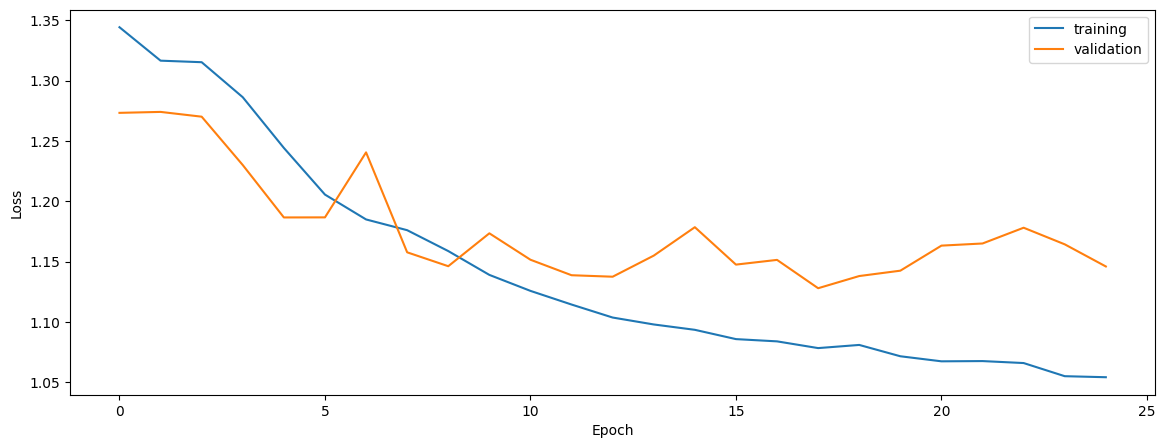

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6326902362482004
0.6418694690265486
0.6646408057600518


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6326902362482004
0.6418694690265486
0.6646408057600518


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6368947373282389
0.6559241706161137
0.6652569113071976


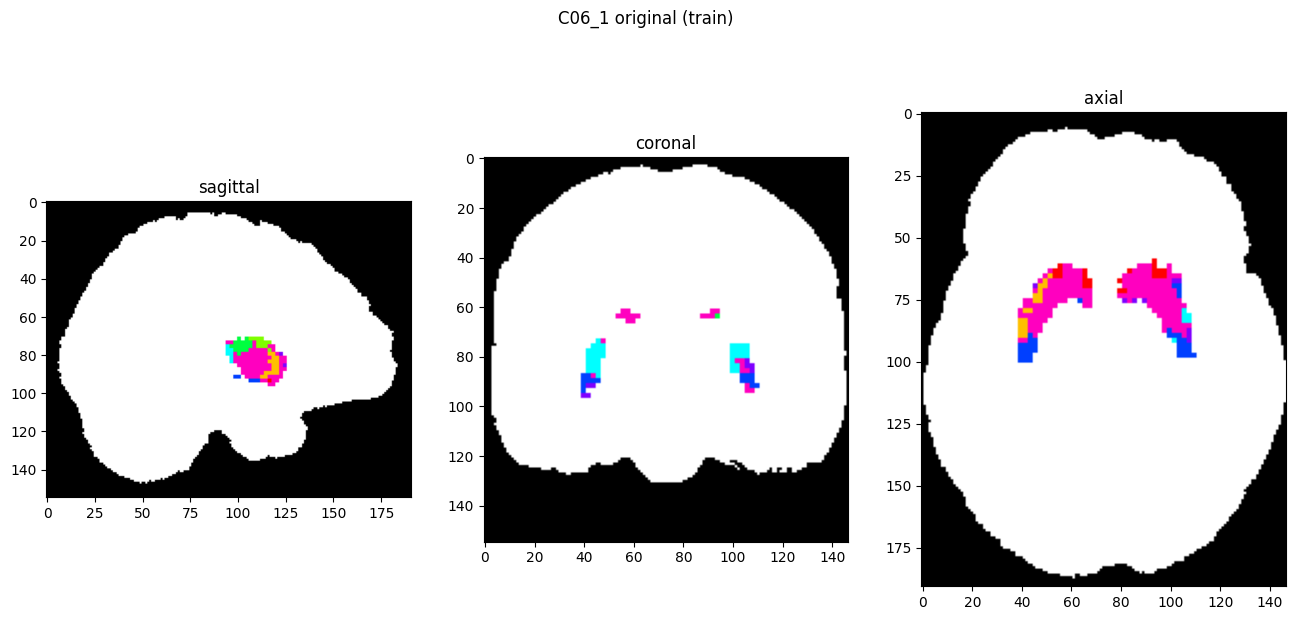

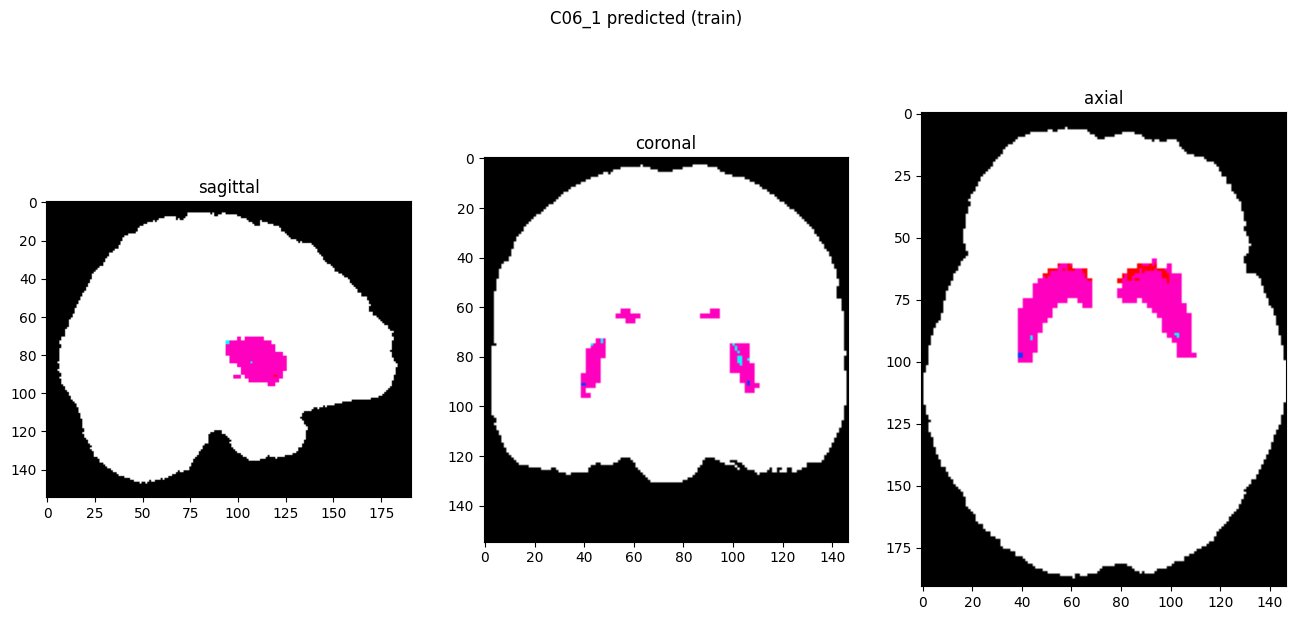

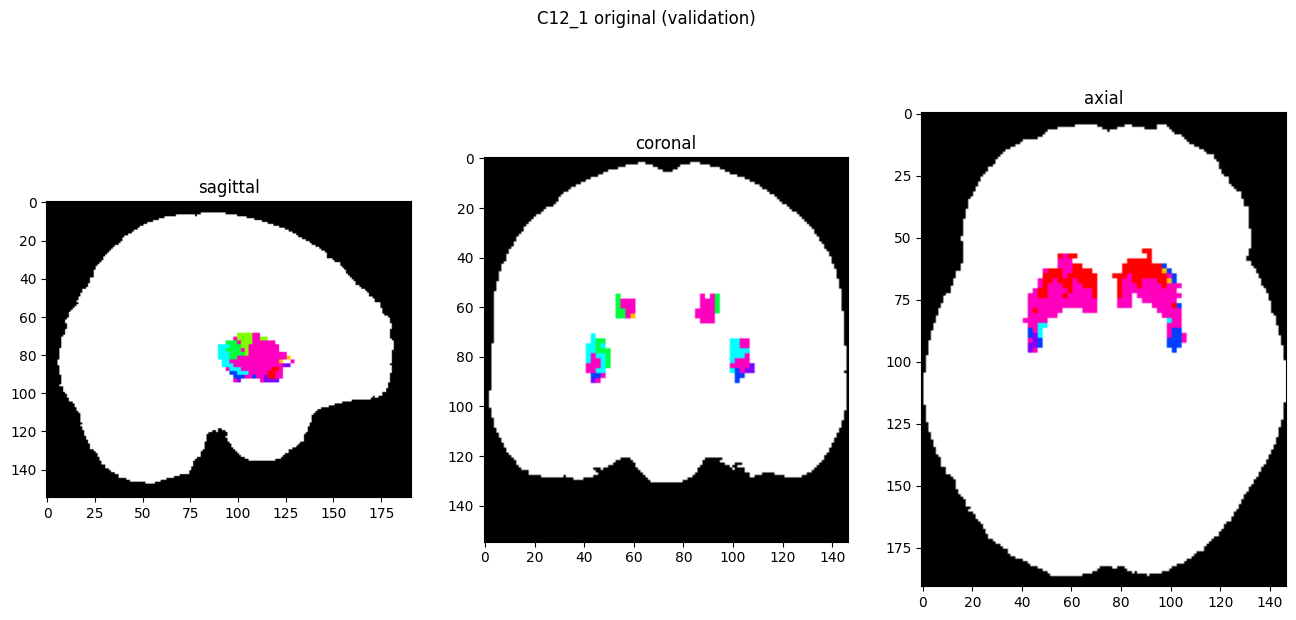

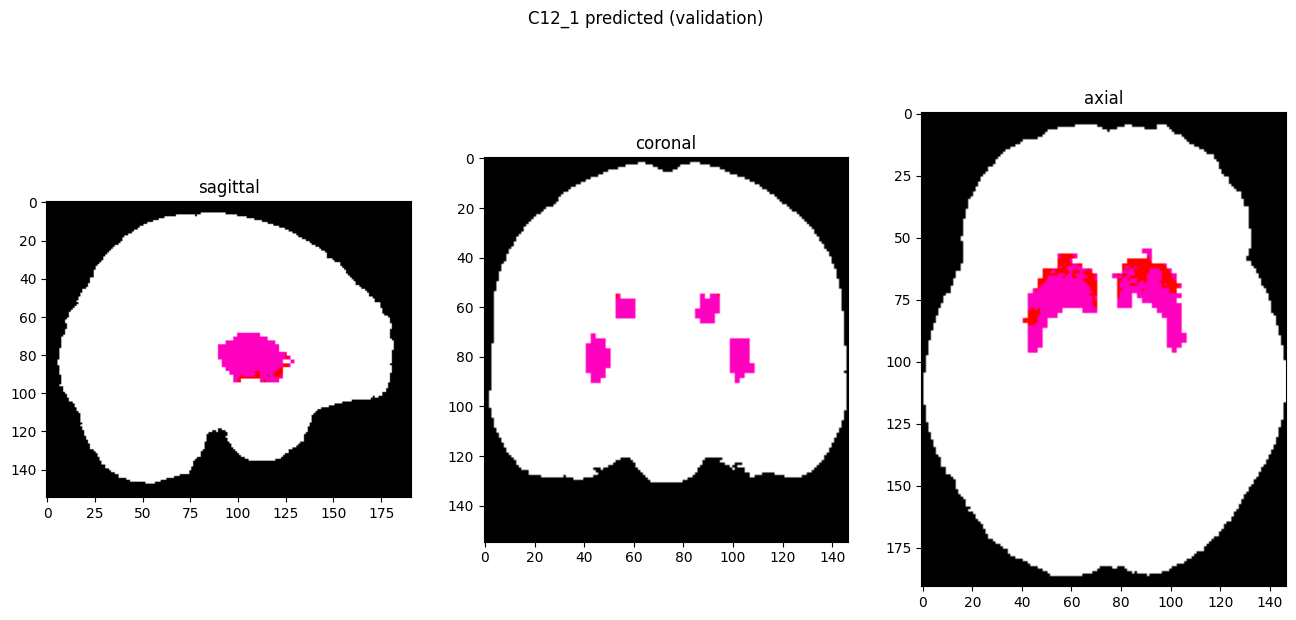

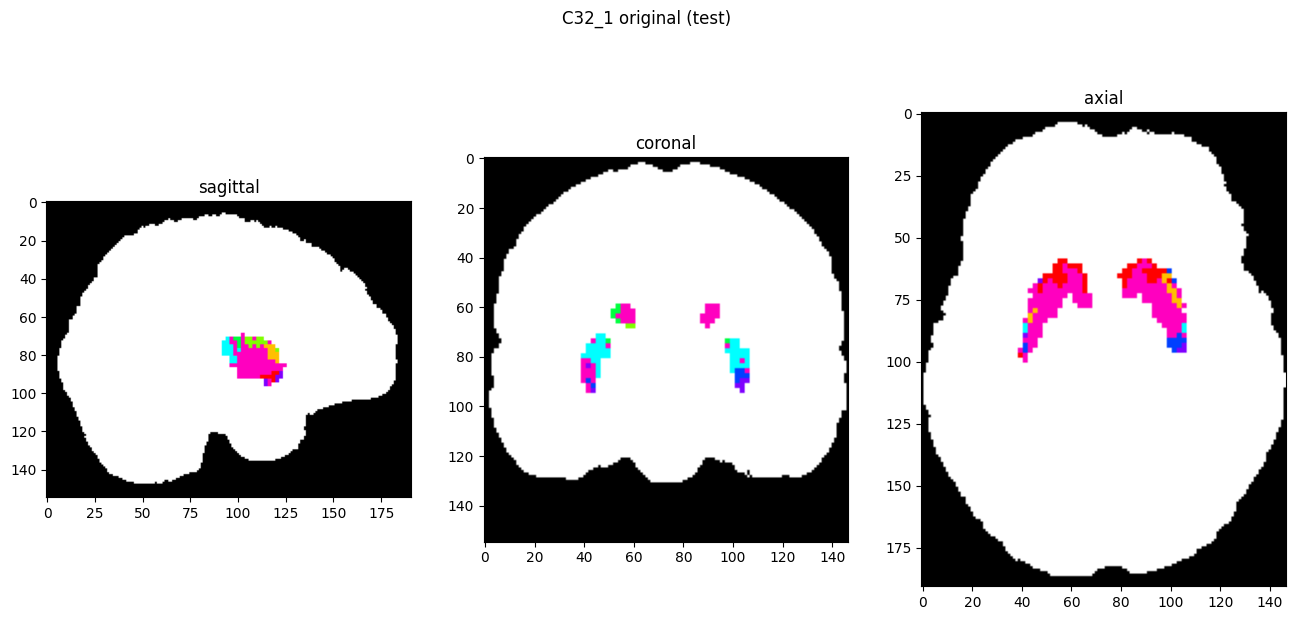

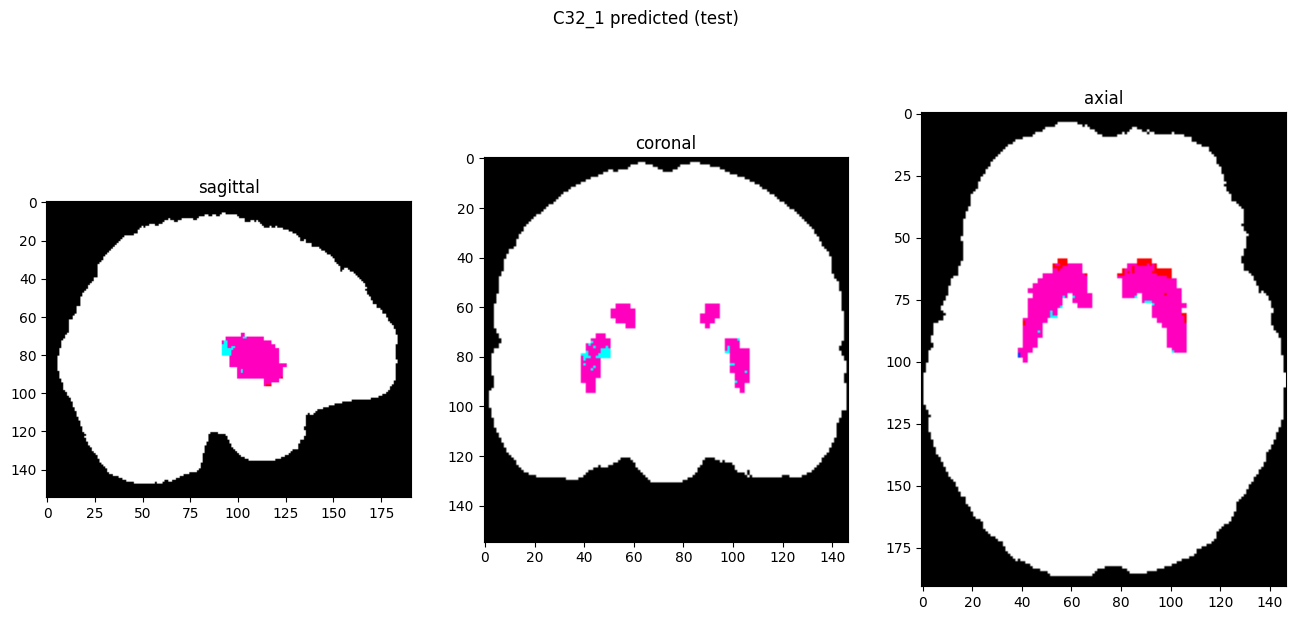

In [10]:
showResults(model, gen, threshold=0)